# Setup and Load Data

To launch virtual environment:
- Open powershell terminal
- Navigate to directory C:\Users\sprin\Research\flexIOproj (use cd .. to move back a level)
- Type flexIOenv\Scripts\Activate.ps1

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None # to turn off SettingWithCopyWarning
from datetime import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import itertools
import os
import gurobipy as gp
from gurobipy import GRB
from IPython.display import Image
import glob
from PIL import Image as img
import seaborn as sns
from datetime import datetime
from dateutil.parser import parse

In [2]:
root = "data/myfitnesspal/"

In [2]:
# Load pre-processed data csv files
raw_users = pd.read_csv("data/myfitnesspal/myfitnesspal_users.csv")
raw_foods = pd.read_csv("data/myfitnesspal/myfitnesspal_foods.csv")

In [75]:
def met_goal(data):
    x = np.array(data[['calories', 'carbs', 'fat', 'protein', 'sodium', 'sugar']])
    x[3] = -x[3]
    goal = np.array(data[['goal_calories', 'goal_carbs', 'goal_fat', 'goal_protein', 'goal_sodium', 'goal_sugar']])
    goal[3] = -goal[3]

    # met = (x <= goal).all()
    num_met = sum(x <= goal)
    if num_met == 6:
        met = True
    else:
        met = False
    abs_diff = sum(abs((x - goal))[x > goal])
    if (goal != 0).all():
        rel_diff = sum((abs((x - goal)/goal))[x > goal])
    else:
        rel_diff = sum((abs((x - goal))/np.maximum(goal, 1))[x > goal])

    return met, num_met, abs_diff, rel_diff

# Get which users met goals or not
print(raw_foods.shape)
# Filter for entries with all chosen nutrients goals present
users = raw_users[['user_id', 'date', 'calories', 'carbs', 'fat', 'protein', 'sodium', 'sugar',
            'goal_calories', 'goal_carbs', 'goal_fat', 'goal_protein', 'goal_sodium', 'goal_sugar']]
users = users.dropna()
print(users.shape)
print("Data includes a total of ", len(raw_users), "daily entries (", len(users), "with no missing values), for a total of",
      len(raw_foods), "unique food items and ", len(users.user_id.unique()), "unique users")

goal_metrics = users.apply(met_goal, axis=1)


(6502747, 26)
(256867, 14)
Data includes a total of  587187 daily entries ( 256867 with no missing values), for a total of 6502747 unique food items and  4669 unique users


In [76]:
# Fix negation of protein goals and realized amounts

vec = [list(i) for i in zip(*goal_metrics)]
users["met_goals"] = vec[0]
users["num_met"] = vec[1]
users["abs_diff"] = vec[2]
users["rel_diff"] = vec[3]

# Save a csv copy of the processed user data
users.to_csv(root+"processed/processed_goals.csv")

# Helper Functions

### Data Prep

In [5]:
def date_to_int(data):
    try:
        # Parse the input date string into a datetime object
        date_str = data['date']
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        # Define a reference date (e.g., 2000-01-01)
        reference_date = datetime(2014, 9, 13)

        # Calculate the difference in days between the input date and the reference date
        delta = date_obj - reference_date

        # Convert the delta to a float representing the number of days
        float_date = delta.days

        return int(float_date)
    except ValueError:
        # Handle invalid date format
        return None

In [6]:
# X: Observation(s)
def getObs(obs, day, foods, Sample):
    observation = []
    print(len(Sample[Sample['day'] == day]), "foods eaten", end=", ")
    for food in foods:
        count = len(Sample[(Sample['day'] == day) & (Sample['description'] == food)])
        observation.append(count)
    obs["Day " + str(int(day))] = observation
    X = obs.to_numpy(); X = X[:,1:]; X = X.T; X = X.astype("float")

    return X, obs

In [7]:
def get_model_params(userID, day, users, foods, data_filtered):
    if data_filtered == False:
        # Filter for userID and calculate day for user
        userGoals = users[users['user_id']==userID]
        userGoals.loc[:,'day'] = userGoals.apply(date_to_int, axis=1)
        userFoods = foods[foods['user_id']==userID]
        userFoods.loc[:,'day'] = userFoods.apply(date_to_int, axis=1)
        Sample = userFoods
    else:
        Sample = foods
        userGoals = users

    # Sample = Sample.astype(str)
    # Sample = Sample.fillna(0)
    # Sample.replace("--", 0, inplace=True)

    print("Total sample size: " + str(Sample.size))
    
    foods = Sample["food name"].unique()
    print(str(foods.shape[0]) + " unique foods")
    obs = pd.DataFrame(foods)

    # Observation(s)
    X, obs = getObs(obs, day, foods, Sample)
    X = X[0]

    # A: Nutrients
    AT = Sample.drop(columns=['user_id', 'day', 'date', 'description', 'food_name', 'brand', 'flavor', 
                              'serving_size']); AT = AT.drop_duplicates()
    AT = AT[['calories', 'carbs', 'fat', 'protein', 'sodium', 'sugar']]
    AT = AT.astype('float').to_numpy()
    AT[3] = -AT[3]
    A = AT.T


    # b: Diet Bounds
    goals = userGoals
    goals = goals[goals.day == day]
    if len(goals) != 0:
        b = np.array(goals[['goal_calories', 'goal_carbs', 'goal_fat', 'goal_protein', 'goal_sodium', 'goal_sugar']])
        b = b[0]; # b[3] = -b[3]
        print("b: " + str(b.shape), end=', ')
        print(b, end=", ")
    else:
        b = None
        print("No data for day")

    return A, b, X, foods

In [8]:
def get_daily_params(goals_df, foods_df, date):

    # Sample = Sample.astype(str)
    # Sample = Sample.fillna(0)
    # Sample.replace("--", 0, inplace=True)

    # print("Total sample size: " + str(Sample.size))
    foods_df = foods_df[foods_df.date == date]
    foods = foods_df["description"].unique()
    # print(str(foods.shape[0]) + " unique foods")
    obs = pd.DataFrame(foods)

    # Observation(s)
    observation = []
    for food in foods:
        count = len(foods_df[foods_df['description'] == food])
        observation.append(count)
    obs["Day " + date] = observation
    X = obs.to_numpy(); X = X[:,1:]; X = X.T; X = X.astype("float")

    # X, obs = getObs(obs, day, foods, Sample)
    X = X[0]

    # A: Nutrients
    AT = foods_df.drop(columns=['date']); AT = AT.drop_duplicates(subset=["description"])
    AT = AT[['calories', 'carbs', 'fat', 'protein', 'sodium', 'sugar']]
    AT = AT.astype('float').to_numpy()
    A = AT.T

    # b: Diet Bounds
    goals_df = goals_df[goals_df.date == date]
    if len(goals_df) != 0:
        b = np.array(goals_df[['goal_calories', 'goal_carbs', 'goal_fat', 'goal_protein', 'goal_sodium', 'goal_sugar']])
        b = b[0]; b[3] = -b[3]
        print("b", end=': ')
        print(b, end=", ")
    else:
        b = None
        print("No data for day")

    return A, b, X, foods

In [9]:
def get_multi_params(goals_df, foods_df, dates):

    foods = foods_df["food name"].unique()

    # Observation(s)
    print(len(foods), "unique foods eaten", end=", ")
    X = np.empty(shape=(len(dates), len(foods)))
    f = 0
    for food in foods:
        d = 0
        for date in dates:
            date_obj = datetime.strptime(date, '%Y-%m-%d')
            date_str = "{}/{}/{}".format(date_obj.month, date_obj.day, str(date_obj.year))
            servings = sum(foods_df[(foods_df["date"]==date_str) & (foods_df["food name"]==food)]["num servings"])
            X[d,f] = servings
            d += 1
        f += 1

    # A: Nutrients
    AT = foods_df.drop(columns=['user_id', 'date', 'description', 'food_name', 'brand', 'flavor', 
                              'serving_size']); AT = AT.drop_duplicates(subset=["food name"])
    AT = AT[['calories', 'carbs', 'fat', 'protein', 'sodium', 'sugar']]
    AT = AT.astype('float').to_numpy()
    A = AT.T
    A[3,:] = -A[3,:]

    # b: Diet Bounds
    goals_df = goals_df[goals_df.date.isin(dates)]
    if len(goals_df) != 0:
        b = np.array(goals_df[['goal_calories', 'goal_carbs', 'goal_fat', 'goal_protein', 'goal_sodium', 'goal_sugar']])
        b = b[0]; # b[3] = -b[3]
        print("b", end=': ')
        print(b, end=", ")
    else:
        b = None
        print("No data for day")

    return A, b, X, foods

In [10]:
def model_params(goals_df, foods_df, dates):

    foods = foods_df["food name"].unique()

    # Observation(s)
    print(len(foods), "unique foods eaten", end=", ")
    X = np.empty(shape=(len(dates), len(foods)))
    f = 0
    for food in foods:
        d = 0
        for date in dates:
            date_obj = datetime.strptime(date, '%Y-%m-%d')
            date_str = "{}/{}/{}".format(date_obj.month, date_obj.day, str(date_obj.year))
            servings = sum(foods_df[(foods_df["date"]==date_str) & (foods_df["food name"]==food)]["num servings"])
            X[d,f] = servings
            d += 1
        f += 1

    # A: Nutrients
    AT = foods_df.drop(columns=['user_id', 'date', 'description', 'food_name', 'brand', 'flavor', 
                              'serving_size']); AT = AT.drop_duplicates(subset=["food name"])
    AT = AT[['calories', 'carbs', 'fat', 'protein', 'sodium', 'sugar']]
    AT = AT.astype('float').to_numpy()
    AT  = np.column_stack((AT, -AT))
    A = AT.T

    # b: Diet Bounds
    goals_df = goals_df[goals_df.date.isin(dates)]
    if len(goals_df) != 0:
        goals = np.array(goals_df[['goal_calories', 'goal_carbs', 'goal_fat', 'goal_protein', 'goal_sodium', 'goal_sugar']])
        # +5% / -15% of calories goal
        cal_UB = goals_df['goal_calories'].iloc[0] + .05*goals_df['goal_calories'].iloc[0]
        cal_LB = max(goals_df['goal_calories'].iloc[0] - .15*goals_df['goal_calories'].iloc[0], 0)
        # +5% / -25% of carbs goal
        carb_UB = goals_df['goal_carbs'].iloc[0] + .05*goals_df['goal_carbs'].iloc[0]
        carb_LB = max(goals_df['goal_carbs'].iloc[0] - .25*goals_df['goal_carbs'].iloc[0], 0)
        # +5% / -25% of fat goal
        fat_UB = goals_df['goal_fat'].iloc[0] + .05*goals_df['goal_fat'].iloc[0]
        fat_LB = max(goals_df['goal_fat'].iloc[0] - .25*goals_df['goal_fat'].iloc[0], 0)
        # +100% / -5% of protein goal
        prot_UB = goals_df['goal_protein'].iloc[0] + goals_df['goal_protein'].iloc[0]
        prot_LB = max(goals_df['goal_protein'].iloc[0] - .05*goals_df['goal_protein'].iloc[0], 0)
        # +5% / -50% of sodium goal
        sod_UB = goals_df['goal_sodium'].iloc[0] + .05*goals_df['goal_sodium'].iloc[0]
        sod_LB = max(goals_df['goal_sodium'].iloc[0] - .5*goals_df['goal_sodium'].iloc[0], 0)
        # +5% / 0 min of sugar goal
        sug_UB = goals_df['goal_sugar'].iloc[0] + .05*goals_df['goal_sugar'].iloc[0]
        sug_LB = 0

        b = np.array([cal_UB, carb_UB, fat_UB, prot_UB, sod_UB, sug_UB, 
                    -cal_LB, -carb_LB, -fat_LB, -prot_LB, -sod_LB, -sug_LB])

        print("b", end=': ')
        print(b, end=", ")
    else:
        b = None
        print("No data for day")

    return A, b, X, foods

### Plotting

In [11]:
def init_user(userID, all_users):
    userID = 4920
    userGoals = all_users[all_users['user_id']==userID]
    userFoods = pd.read_csv(root+"User4920_Foods_standardized.csv")
    print(len(userGoals), "daily entries with", len(userFoods["food name"].unique()), "total unique food items")

    diet_df = pd.DataFrame({'Calories': userGoals.calories/userGoals.goal_calories, 'Sodium': userGoals.sodium/userGoals.goal_sodium,
                            'Carbs': userGoals.carbs/userGoals.goal_carbs, 'Fat': userGoals.fat/userGoals.goal_fat, 
                            'Protein': userGoals.protein/userGoals.goal_protein,  'Sugar': userGoals.sugar/userGoals.goal_sugar})
    ax = sns.boxplot(diet_df)
    ax.set(xlabel="Nutrient", ylabel="Portion of goal consumed", title="User "+str(userID))
    plt.savefig("data/output/User"+str(userID)+"/User"+str(userID)+"_Boxplot.png")

    plt.rcParams.update({'font.size': 10})
    fig, axes = plt.subplots(2, 2, figsize=(10,5))
    x = np.linspace(1, len(userGoals), len(userGoals))
    axes[0][0].plot(x, userGoals.goal_calories, label="calories", color='tab:blue')
    axes[0][0].plot(x, userGoals.goal_sodium, label="sodium", color='tab:orange')
    axes[1][0].plot(x, userGoals.goal_carbs, label="carbs", color='tab:green')
    axes[1][0].plot(x, userGoals.goal_fat, label="fat", color='tab:red')
    axes[1][0].plot(x, userGoals.goal_protein, label="protein", color='tab:purple')
    axes[1][0].plot(x, userGoals.goal_sugar, label="sugar", color='tab:brown')
    axes[0][0].set_ylabel("Daily nutrient goal"); axes[1][0].set_ylabel("Daily nutrient goal")
    axes[1][0].set_xlabel("Day")

    axes[0][1].plot(x, userGoals.calories, label="calories", color='tab:blue')
    axes[0][1].plot(x, userGoals.sodium, label="sodium", color='tab:orange')
    axes[1][1].plot(x, userGoals.carbs, label="carbs", color='tab:green')
    axes[1][1].plot(x, userGoals.fat, label="fat", color='tab:red')
    axes[1][1].plot(x, userGoals.protein, label="protein", color='tab:purple')
    axes[1][1].plot(x, userGoals.sugar, label="sugar", color='tab:brown')
    axes[0][1].set_ylabel("Nurtient consumption"); axes[1][1].set_ylabel("Nurtient consumption")
    axes[1][1].set_xlabel("Day")

    lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0][0], axes[1][0]]]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc='upper center', ncol=3)
    plt.savefig("data/output/User"+str(userID)+"/User"+str(userID)+"_Trends.png")
    fig.show()

    return userGoals, userFoods

In [67]:
# Plot nutritional changes in recommendation vs observation
def plt_rec_nuts(userID, userGoals, dates, X, X_new1, X_new2, A, b, L, d, day_ind, model):
    nutrients = ["Calories", "Carbs", "Fat", "Protein", "Sodium", "Sugar"]
    obs_cals = gp.quicksum(X[d,i]*A[0,i] for i in range(X.shape[1])).getValue()
    rec1_cals = gp.quicksum(X_new1[d,i]*(A[0,i]) for i in range(X.shape[1])).getValue()
    rec2_cals = gp.quicksum(X_new2[d,i]*(A[0,i]-L[0,i]) for i in range(X.shape[1])).getValue()
    goal_cals = userGoals.iloc[day_ind]["goal_calories"]
    obs_carbs = gp.quicksum(X[d,i]*A[1,i] for i in range(X.shape[1])).getValue()
    rec1_carbs = gp.quicksum(X_new1[d,i]*(A[1,i]) for i in range(X.shape[1])).getValue()
    rec2_carbs = gp.quicksum(X_new2[d,i]*(A[1,i]-L[1,i]) for i in range(X.shape[1])).getValue()
    goal_carbs = userGoals.iloc[day_ind]["goal_carbs"]
    obs_fat = gp.quicksum(X[d,i]*A[2,i] for i in range(X.shape[1])).getValue()
    rec1_fat = gp.quicksum(X_new1[d,i]*(A[2,i]) for i in range(X.shape[1])).getValue()
    rec2_fat = gp.quicksum(X_new2[d,i]*(A[2,i]-L[2,i]) for i in range(X.shape[1])).getValue()
    goal_fat = userGoals.iloc[day_ind]["goal_fat"]
    obs_protein = gp.quicksum(X[d,i]*A[3,i] for i in range(X.shape[1])).getValue()
    rec1_protein = gp.quicksum(X_new1[d,i]*(A[3,i]) for i in range(X.shape[1])).getValue()
    rec2_protein = gp.quicksum(X_new2[d,i]*(A[3,i]-L[3,i]) for i in range(X.shape[1])).getValue()
    goal_protein = userGoals.iloc[day_ind]["goal_protein"]
    obs_sodium = gp.quicksum(X[d,i]*A[4,i] for i in range(X.shape[1])).getValue()
    rec1_sodium = gp.quicksum(X_new1[d,i]*(A[4,i]) for i in range(X.shape[1])).getValue()
    rec2_sodium = gp.quicksum(X_new2[d,i]*(A[4,i]-L[4,i]) for i in range(X.shape[1])).getValue()
    goal_sodium = userGoals.iloc[day_ind]["goal_sodium"]
    obs_sugar = gp.quicksum(X[d,i]*A[5,i] for i in range(X.shape[1])).getValue()
    rec1_sugar = gp.quicksum(X_new1[d,i]*(A[5,i]) for i in range(X.shape[1])).getValue()
    rec2_sugar = gp.quicksum(X_new2[d,i]*(A[5,i]-L[5,i]) for i in range(X.shape[1])).getValue()
    goal_sugar = userGoals.iloc[day_ind]["goal_sugar"]

    obs_df = pd.DataFrame({"Day": d, "Calories": obs_cals, "Carbs": obs_carbs, "Fat": obs_fat, "Protein": obs_protein, "Sodium": obs_sodium, "Sugar": obs_sugar}, index=[0])
    recs1_df = pd.DataFrame({"Day": d, "Calories": rec1_cals, "Carbs": rec1_carbs, "Fat": rec1_fat, "Protein": rec1_protein, "Sodium": rec1_sodium, "Sugar": rec1_sugar}, index=[0])
    recs2_df = pd.DataFrame({"Day": d, "Calories": rec2_cals, "Carbs": rec2_carbs, "Fat": rec2_fat, "Protein": rec2_protein, "Sodium": rec2_sodium, "Sugar": rec2_sugar}, index=[0])
    goals_df = pd.DataFrame({"Day": d, "Calories": goal_cals, "Carbs": goal_carbs, "Fat": goal_fat, "Protein": goal_protein, "Sodium": goal_sodium, "Sugar": goal_sugar}, index=[0])
    
    # Set the width of each bar
    bar_width = 0.25

    # Set the positions of the bars on the x-axis
    r2 = range(len(nutrients))
    r1 = [x - bar_width for x in r2]
    r3 = [x + bar_width for x in r2]

    # Create the bar plot
    plt.figure(figsize=(12, 6)); plt.grid(visible=True, axis='y'); plt.rcParams['font.size'] = 6
    plt.rcParams.update({'font.size': 10})
    container = plt.bar(r1, 100*(obs_df.iloc[0,1:] - goals_df.iloc[0,1:])/goals_df.iloc[0,1:], width=bar_width, label='Original Behavior', color="cornflowerblue")
    plt.bar_label(container, labels=obs_df.iloc[0,1:].astype(int))
    container = plt.bar(r2, 100*(recs1_df.iloc[0,1:] - goals_df.iloc[0,1:])/goals_df.iloc[0,1:], width=bar_width, label='IL', color="orange")
    plt.bar_label(container, labels=recs1_df.iloc[0,1:].astype(int))
    container = plt.bar(r3, 100*(recs2_df.iloc[0,1:] - goals_df.iloc[0,1:])/goals_df.iloc[0,1:], width=bar_width, label='CDH-IL', color="orchid")
    plt.bar_label(container, labels=recs2_df.iloc[0,1:].astype(int))

    # Define the acceptable range for each nutrient
    day_goals = userGoals[userGoals.date.isin(dates)].iloc[0]
    acceptable_ranges = {
        'Calories': (100*(-b[6] - day_goals['goal_calories'])/day_goals['goal_calories'], 
                     100*(b[0] - day_goals['goal_calories'])/day_goals['goal_calories']),
        'Carbs': (100*(-b[7] - day_goals['goal_carbs'])/day_goals['goal_carbs'], 
                  100*(b[1] - day_goals['goal_carbs'])/day_goals['goal_carbs']),
        'Fat': (100*(-b[8] - day_goals['goal_fat'])/day_goals['goal_fat'], 
                100*(b[2] - day_goals['goal_fat'])/day_goals['goal_fat']),
        'Protein': (100*(-b[9] - day_goals['goal_protein'])/day_goals['goal_protein'], 
                    100*(b[3] - day_goals['goal_protein'])/day_goals['goal_protein']),
        'Sodium': (100*(-b[10] - day_goals['goal_sodium'])/day_goals['goal_sodium'], 
                   100*(b[4] - day_goals['goal_sodium'])/day_goals['goal_sodium']),
        'Sugar': (100*(-b[11] - day_goals['goal_sugar'])/day_goals['goal_sugar'], 
                  100*(b[5] - day_goals['goal_sugar'])/day_goals['goal_sugar'])}

    # Add green bands for acceptable ranges
    for i, nutrient in enumerate(nutrients):
        lower_bound, upper_bound = acceptable_ranges[nutrient]
        plt.axhspan(lower_bound, upper_bound, facecolor='g', alpha=0.2, xmin=i / len(nutrients), xmax=(i + 1) / len(nutrients))


    # Add labels and title
    plt.xlabel('Nutrients')
    plt.ylabel('Difference from goal (%)')
    plt.title('Day '+ str(d+1) +' Nutrient Recommendations Results')
    nutrient_labels = ["Calories ("+str(round(goals_df.iloc[0]["Calories"]))+")", 
                       "Carbs ("+str(round(goals_df.iloc[0]["Carbs"]))+")", 
                       "Fat ("+str(round(goals_df.iloc[0]["Fat"]))+")", 
                       "Protein ("+str(round(goals_df.iloc[0]["Protein"]))+")", 
                       "Sodium ("+str(round(goals_df.iloc[0]["Sodium"]))+")", 
                       "Sugar ("+str(round(goals_df.iloc[0]["Sugar"]))+")"]
    plt.xticks([r  for r in range(len(nutrients))], nutrient_labels); # plt.tick_params(axis='x', labelsize=12)
    # plt.legend(bbox_to_anchor=(0.75, 1.15), loc="upper left")
    plt.savefig("data/output/User"+str(userID)+"/User"+str(userID)+"_"+model+"_Day_"+str(d+1)+"_Nutrients.png")
    
    plt.close()

In [13]:
# Plot food portion changes in recommendation vs observation
def plt_foods2(userID, results, d, model):
    
    obs = results['Observation '+str(d+1)]!=0
    rec = results['Recommendation '+str(d+1)]!=0
    dayResults = results.loc[obs + rec]
    dayResults = dayResults[["Foods", "Observation "+str(d+1), "Recommendation "+str(d+1), "A_calories", "A_carbs", "A_fat", "A_protein", 
                            "A_sodium", "A_sugar"]]
    food_groups = dayResults["Foods"][1:]
    first_values = []; second_values = []
    for i in range(len(dayResults)):
        if dayResults["Observation "+str(d+1)].iloc[i] == 0:
            first_values.append(0)
            second_values.append(dayResults["Recommendation "+str(d+1)].iloc[i])
        else: 
            first_values.append(1)
            second_values.append(dayResults["Recommendation "+str(d+1)].iloc[i]/dayResults["Observation "+str(d+1)].iloc[i])

    # Set the width of each bar
    bar_width = 0.35

    # Set the positions of the bars on the x-axis
    r1 = range(len(food_groups))
    r2 = [x + bar_width for x in r1]

    # Create the bar plot
    plt.figure(figsize=(12, 12))
    plt.rcParams.update({'font.size': 12})
    plt.bar(r1, first_values[1:], width=bar_width, label='Original Behavior')
    plt.bar(r2, second_values[1:], width=bar_width, label='Recommendation')

    # Add labels and title
    plt.xlabel('Food Groups')
    plt.ylabel('Values')
    plt.title('Day ' + str(d+1) + ' Food Groups vs. Values')
    plt.xticks([r  for r in range(len(food_groups))], food_groups, rotation=90)
    # Add legend
    plt.legend(bbox_to_anchor=(0.75, 1.2), loc="upper left")
    # Adjust layout 
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.6, top=0.925)
    # plt.tight_layout()
    
    plt.savefig("data/output/User"+str(userID)+"/User"+str(userID)+"_"+model+"_Day_"+str(d+1)+"_Foods.png")
    plt.close()

In [34]:
# Plot food portion changes in recommendation vs observation
def plt_foods(userID, X, X_new1, X_new2, foods, d, model):
    obs = X[d].T!=0
    rec1 = X_new1[d].T!=0; rec2 = X_new2[d].T!=0
    dayResults = {"Observation": X[d][obs+rec1+rec2], "Recommendation 1": X_new1[d][obs+rec1+rec2], "Recommendation 2": X_new2[d][obs+rec1+rec2]}
    # print(len(dayResults["Observation"])); print(dayResults["Observation"])
    first_values = []; second_values = []; third_values = []
    for i in range(len(dayResults["Observation"])):
        if dayResults["Observation"][i] == 0:
            first_values.append(0)
            second_values.append(dayResults["Recommendation 1"][i])
            third_values.append(dayResults["Recommendation 2"][i])
        else: 
            first_values.append(1)
            second_values.append(dayResults["Recommendation 1"][i]/dayResults["Observation"][i])
            third_values.append(dayResults["Recommendation 2"][i]/dayResults["Observation"][i])

    # Set the width of each bar
    bar_width = 0.25

    # Set the positions of the bars on the x-axis
    r2 = range(len(foods[obs+rec1+rec2]))
    r1 = [x - bar_width for x in r2]
    r3 = [x + bar_width for x in r2]

    # Create the bar plot
    plt.figure(figsize=(12, 12))
    plt.rcParams.update({'font.size': 12})
    plt.bar(r1, first_values, width=bar_width, label='Original Behavior', color="cornflowerblue")
    plt.bar(r2, second_values, width=bar_width, label='IL', color="orange")
    plt.bar(r3, third_values, width=bar_width, label='CDH-IL', color="orchid")

    # Add labels and title
    plt.xlabel('Food Groups')
    plt.ylabel('Values')
    plt.title('Day ' + str(d+1) + ' Food Groups vs. Values')
    plt.xticks([r  for r in range(len(foods[obs+rec1+rec2]))], foods[obs+rec1+rec2], rotation=90)
    # Add legend
    # plt.legend(bbox_to_anchor=(0.75, 1.2), loc="upper left")
    # Adjust layout 
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.6, top=0.925)
    # plt.tight_layout()
    
    plt.savefig("data/output/User"+str(userID)+"/User"+str(userID)+"_"+model+"_Day_"+str(d+1)+"_Foods.png")
    plt.close()

# Data Exploration

A total of 7771 entries ( 3.03 %), with 1875 unique users, met all goals
A total of 15319 entries ( 5.96 %), with 2549 unique users, were within 10% of original goal


C:\Users\sprin\AppData\Local\Temp\ipykernel_9168\661278686.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\sprin\AppData\Local\Temp\ipykernel_9168\661278686.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\sprin\AppData\Local\Temp\ipykernel_9168\661278686.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


A total of 19963 entries ( 7.77 %), with 2818 unique users, were within 15% of original goal


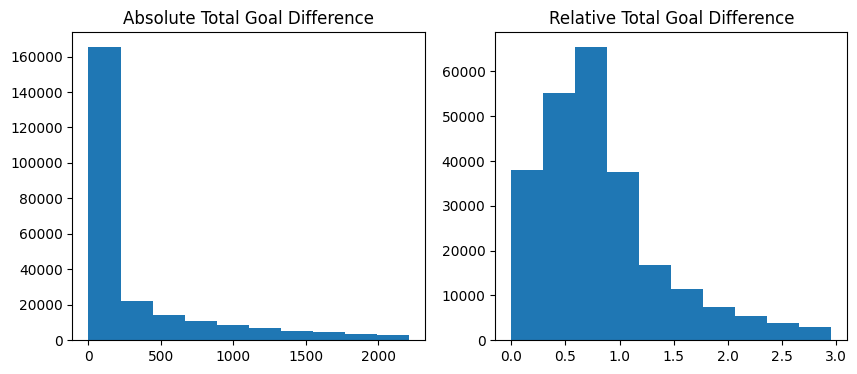

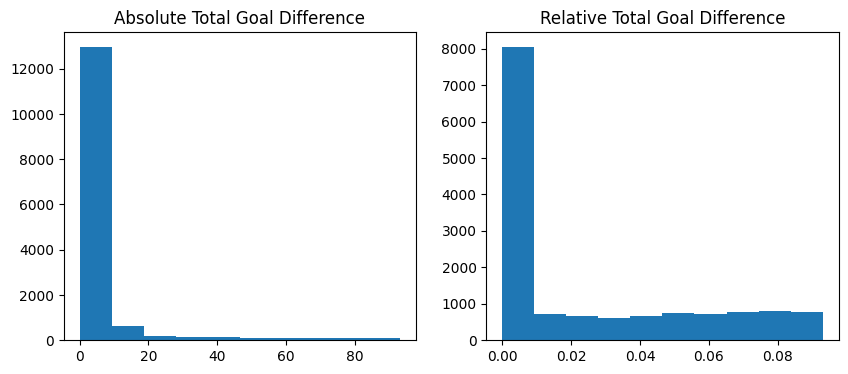

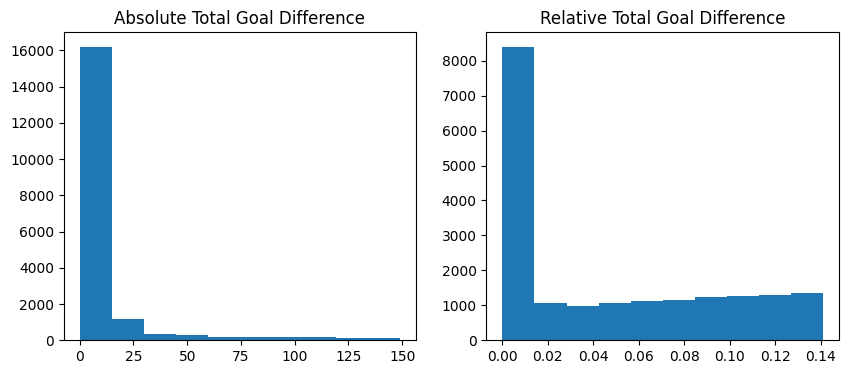

In [15]:
users = pd.read_csv(root+"processed/processed_goals.csv")
df0 = users[users.met_goals==True]
print("A total of", str(len(df0)), "entries (" , str(round(100*len(df0)/users.shape[0], 2)),
       "%), with", len(df0.user_id.unique()), "unique users, met all goals")

all_users = users

df10 = users[users.rel_diff <= 0.1]
print("A total of", str(len(df10)), "entries (" , str(round(100*len(df10)/users.shape[0], 2)), "%), with", len(df10.user_id.unique()), "unique users, were within 10% of original goal")

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(users.abs_diff, range=(np.min(users.abs_diff), np.sort(users.abs_diff)[round(len(users)*.95)])); ax[0].set_title("Absolute Total Goal Difference")
ax[1].hist(users.rel_diff, range=(np.min(users.rel_diff), np.sort(users.rel_diff)[round(len(users)*.95)])); ax[1].set_title("Relative Total Goal Difference")
fig.show()

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(df10.abs_diff, range=(np.min(df10.abs_diff), np.sort(df10.abs_diff)[round(len(df10)*.95)])); ax[0].set_title("Absolute Total Goal Difference")
ax[1].hist(df10.rel_diff, range=(np.min(df10.rel_diff), np.sort(df10.rel_diff)[round(len(df10)*.95)])); ax[1].set_title("Relative Total Goal Difference")
fig.show()

df15 = users[users.rel_diff <= 0.15]
print("A total of", str(len(df15)), "entries (" , str(round(100*len(df15)/users.shape[0], 2)), "%), with", len(df15.user_id.unique()), "unique users, were within 15% of original goal")
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(df15.abs_diff, range=(np.min(df15.abs_diff), np.sort(df15.abs_diff)[round(len(df15)*.95)])); ax[0].set_title("Absolute Total Goal Difference")
ax[1].hist(df15.rel_diff, range=(np.min(df15.rel_diff), np.sort(df15.rel_diff)[round(len(df15)*.95)])); ax[1].set_title("Relative Total Goal Difference")
fig.show()


37 unique users,  2041 daily entries, and 74305 unique food items after filtering for patients with at least 40 entries


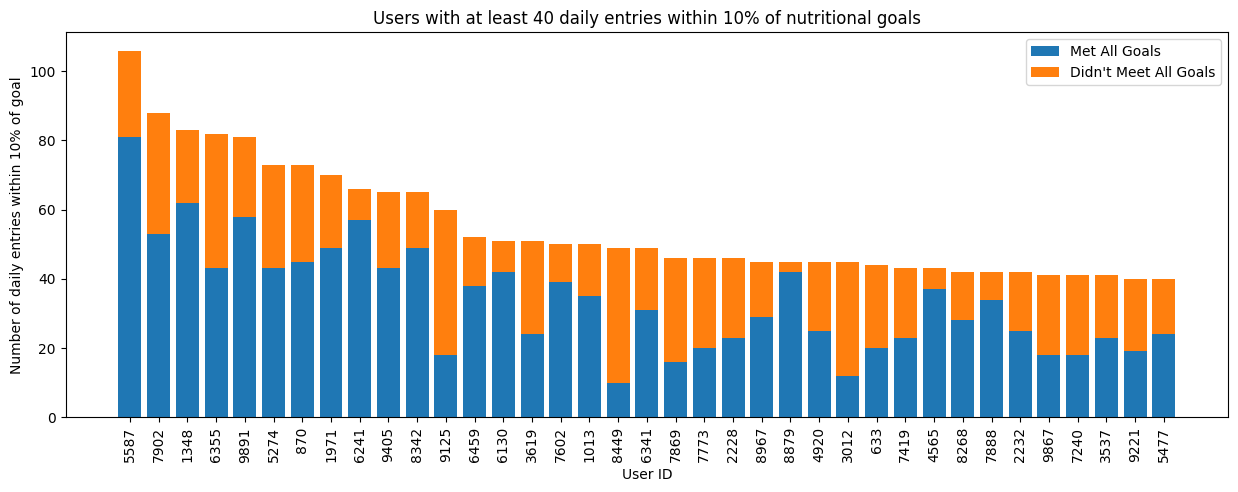

In [16]:
# Filter for users who have at least 40 entries
df10 = users[users.rel_diff <= 0.1]
users = df10
ids, counts = np.unique(users.user_id, return_counts=True)
ids = ids[counts >= 40]
counts = counts[counts >= 40]
goals_10 = users[users.user_id.isin(ids)]
foods_10 = raw_foods[raw_foods.user_id.isin(ids)]
print(len(ids), "unique users, ", len(goals_10), "daily entries, and", len(foods_10), "unique food items after filtering for patients with at least 40 entries")

# Sort by most entries
tuples = sorted(zip(counts, ids), reverse=True)
counts, ids = [t[0] for t in tuples], [t[1] for t in tuples]
# Count how many of the remaining entries met goals vs not
met_True = []; met_False = []
for id in ids:
    met_True.append(np.sum(goals_10[goals_10.user_id == id].met_goals))
    met_False.append(len(goals_10[goals_10.user_id == id])-np.sum(goals_10[goals_10.user_id == id].met_goals))

# Plot
x_pos = np.arange(len(ids))
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(x_pos, met_True, label="Met All Goals"); ax.bar(x_pos, met_False, bottom = met_True, label="Didn't Meet All Goals")
ax.set_xticks(x_pos, labels=ids, rotation=90); ax.set_xlabel("User ID"); ax.set_ylabel("Number of daily entries within 10% of goal")
ax.legend(); ax.set_title("Users with at least 40 daily entries within 10% of nutritional goals")
plt.show()

41 unique users,  2758 daily entries, and 67736 unique food items after filtering for patients with at least 40 entries


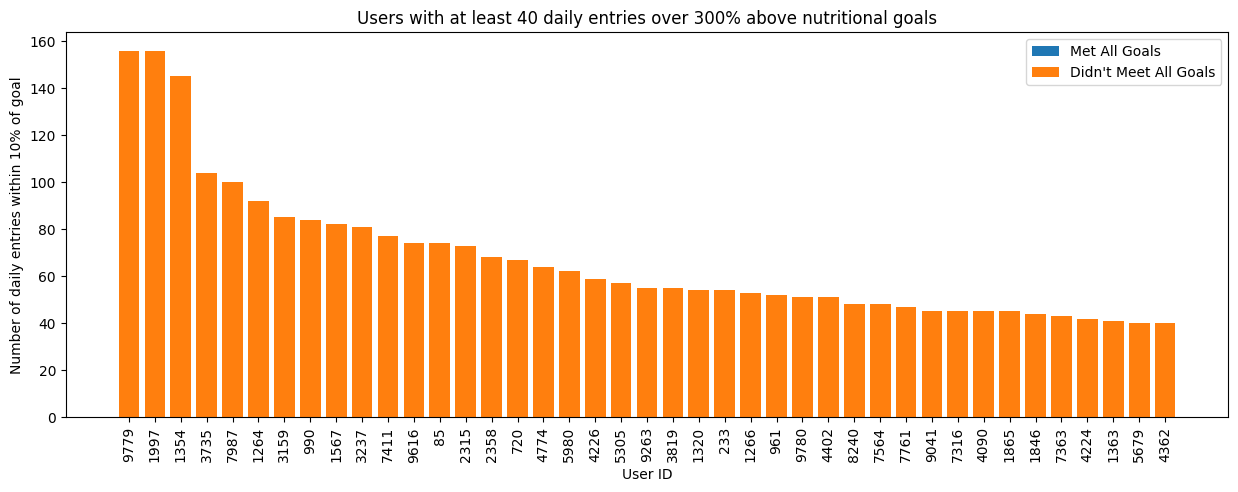

In [17]:
# Get users with at least 40 entries more than 100% (total) away from nutritional goals
df300 = all_users[all_users.rel_diff >= 3]
users = df300
ids, counts = np.unique(users.user_id, return_counts=True)
ids = ids[counts >= 40]
counts = counts[counts >= 40]
goals_300 = users[users.user_id.isin(ids)]
foods_300 = raw_foods[raw_foods.user_id.isin(ids)]
print(len(ids), "unique users, ", len(goals_300), "daily entries, and", len(foods_300), "unique food items after filtering for patients with at least 40 entries")

# Sort by most entries
tuples = sorted(zip(counts, ids), reverse=True)
counts, ids = [t[0] for t in tuples], [t[1] for t in tuples]
# Count how many of the remaining entries met goals vs not
met_True = []; met_False = []
for id in ids:
    met_True.append(np.sum(goals_300[goals_300.user_id == id].met_goals))
    met_False.append(len(goals_300[goals_300.user_id == id])-np.sum(goals_300[goals_300.user_id == id].met_goals))

# Plot
x_pos = np.arange(len(ids))
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(x_pos, met_True, label="Met All Goals"); ax.bar(x_pos, met_False, bottom = met_True, label="Didn't Meet All Goals")
ax.set_xticks(x_pos, labels=ids, rotation=90); ax.set_xlabel("User ID"); ax.set_ylabel("Number of daily entries within 10% of goal")
ax.legend(); ax.set_title("Users with at least 40 daily entries over 300% above nutritional goals")
plt.show()

In [18]:
diff_var = np.var(all_users.rel_diff)
print(diff_var)

3294.9137900579417


6 unique users,  1020 daily entries, and 13760 unique food items after filtering for patients with at least 40 entries


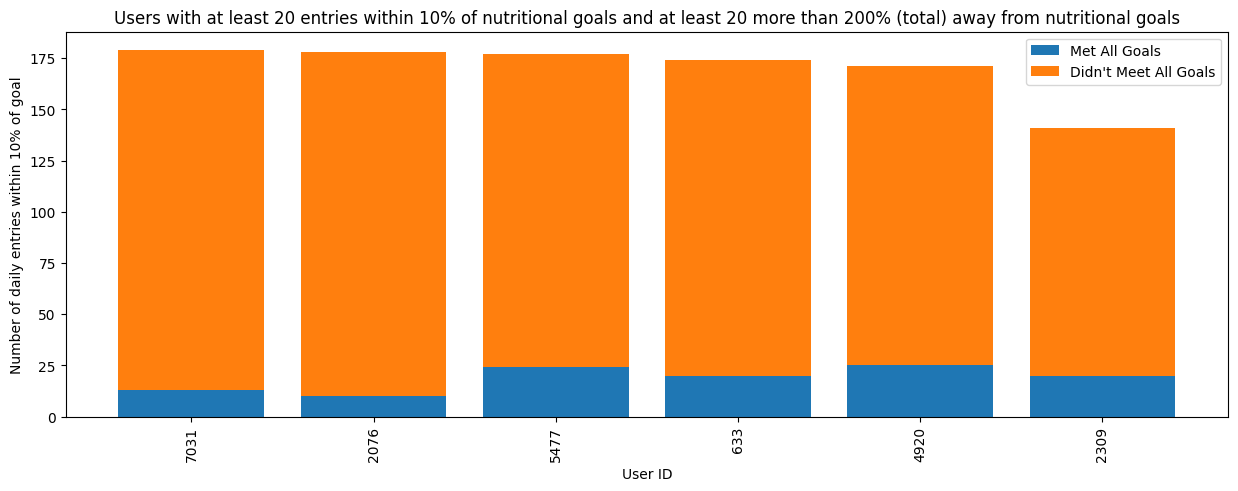

In [19]:
# Get users with at least 20 entries within 10% of nutritional goals and at leaest 20 more than 300% (total) away from nutritional goals
# users = pd.concat((df10, df300))
# ids, counts = np.unique(users.user_id, return_counts=True)

df_green = all_users[all_users.rel_diff <= 0.1]
df_red = all_users[all_users.rel_diff >= 2]
df_greenids, df_greencounts = np.unique(df_green.user_id, return_counts=True)
df_greenids = df_greenids[df_greencounts >= 20]
df_redids, df_redcounts = np.unique(df_red.user_id, return_counts=True)
df_redids = df_redids[df_redcounts >= 20]
ids = list(set(df_greenids).intersection(df_redids))
goals_mix = all_users[all_users.user_id.isin(ids)]
ids, counts = np.unique(goals_mix.user_id, return_counts=True)
foods_mix = raw_foods[raw_foods.user_id.isin(ids)]
print(len(ids), "unique users, ", len(goals_mix), "daily entries, and", len(foods_mix), "unique food items after filtering for patients with at least 40 entries")

# Sort by most entries
tuples = sorted(zip(counts, ids), reverse=True)
counts, ids = [t[0] for t in tuples], [t[1] for t in tuples]

# Count how many of the remaining entries met goals vs not
met_True = []; met_False = []
for id in ids:
    met_True.append(np.sum(goals_mix[goals_mix.user_id == id].met_goals))
    met_False.append(len(goals_mix[goals_mix.user_id == id])-np.sum(goals_mix[goals_mix.user_id == id].met_goals))

# Plot
x_pos = np.arange(len(ids))
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(x_pos, met_True, label="Met All Goals"); 
ax.bar(x_pos, met_False, bottom = met_True, label="Didn't Meet All Goals")
ax.set_xticks(x_pos, labels=ids, rotation=90); ax.set_xlabel("User ID"); ax.set_ylabel("Number of daily entries within 10% of goal")
ax.legend(); ax.set_title("Users with at least 20 entries within 10% of nutritional goals and at least 20 more than 200% (total) away from nutritional goals")
plt.show()

2758


C:\Users\sprin\AppData\Local\Temp\ipykernel_9168\3194391066.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.tight_layout(); fig.show()


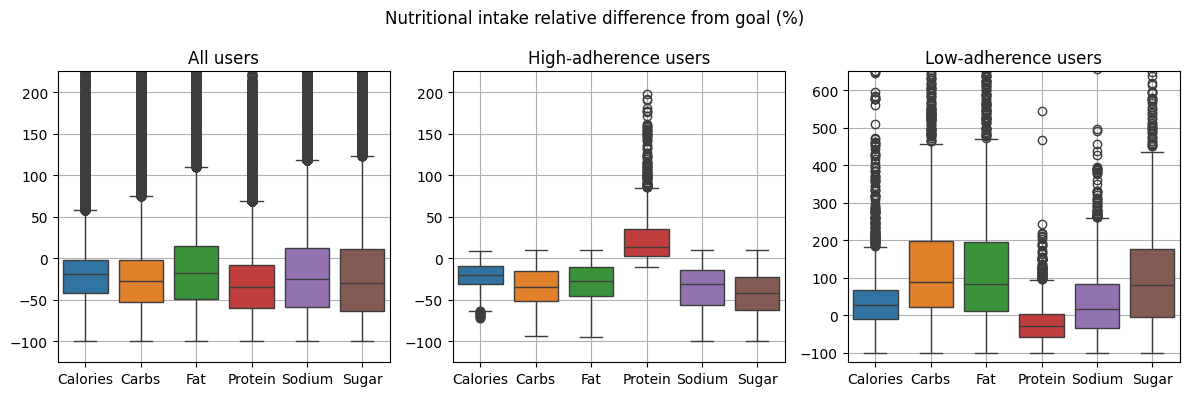

In [20]:
# Create a subplot
fig, axes = plt.subplots(1, 3, figsize=(12,4))

# Plot all users
userGoals = all_users
cal_diff = 100*(userGoals.calories - userGoals.goal_calories)/userGoals.goal_calories
carb_diff = 100*(userGoals.carbs - userGoals.goal_carbs)/userGoals.goal_carbs
fat_diff = 100*(userGoals.fat - userGoals.goal_fat)/userGoals.goal_fat
prot_diff = 100*(userGoals.protein - userGoals.goal_protein)/userGoals.goal_protein
sodium_diff = 100*(userGoals.sodium - userGoals.goal_sodium)/userGoals.goal_sodium
sugar_diff = 100*(userGoals.sugar - userGoals.goal_sugar)/userGoals.goal_sugar
diff_df = pd.DataFrame({'Calories': cal_diff, 'Carbs': carb_diff, 'Fat': fat_diff, 'Protein': prot_diff, 'Sodium': sodium_diff, 'Sugar': sugar_diff})
sns.boxplot(diff_df, ax=axes[0]).set_title("All users")
axes[0].set_ylim(-125, 225) # Restrict axis to exclude extreme outliers
axes[0].grid(True)

# Plot users with at least 40 entries within 10% of goals
userGoals = goals_10
cal_diff = 100*(userGoals.calories - userGoals.goal_calories)/userGoals.goal_calories
carb_diff = 100*(userGoals.carbs - userGoals.goal_carbs)/userGoals.goal_carbs
fat_diff = 100*(userGoals.fat - userGoals.goal_fat)/userGoals.goal_fat
prot_diff = 100*(userGoals.protein - userGoals.goal_protein)/userGoals.goal_protein
sodium_diff = 100*(userGoals.sodium - userGoals.goal_sodium)/userGoals.goal_sodium
sugar_diff = 100*(userGoals.sugar - userGoals.goal_sugar)/userGoals.goal_sugar
diff_df = pd.DataFrame({'Calories': cal_diff, 'Carbs': carb_diff, 'Fat': fat_diff, 'Protein': prot_diff, 'Sodium': sodium_diff, 'Sugar': sugar_diff})
sns.boxplot(diff_df, ax=axes[1]).set_title("High-adherence users")
axes[1].set_ylim(-125, 225); # axes[0].set_ylabel("Percent difference from goal")
axes[1].grid(True)

# Plot users with at least 40 entries over 300% of goals
userGoals = goals_300
print(len(userGoals))
cal_diff = 100*(userGoals.calories - userGoals.goal_calories)/userGoals.goal_calories
carb_diff = 100*(userGoals.carbs - userGoals.goal_carbs)/userGoals.goal_carbs
fat_diff = 100*(userGoals.fat - userGoals.goal_fat)/userGoals.goal_fat
prot_diff = 100*(userGoals.protein - userGoals.goal_protein)/userGoals.goal_protein
sodium_diff = 100*(userGoals.sodium - userGoals.goal_sodium)/userGoals.goal_sodium
sugar_diff = 100*(userGoals.sugar - userGoals.goal_sugar)/userGoals.goal_sugar
diff_df = pd.DataFrame({'Calories': cal_diff, 'Carbs': carb_diff, 'Fat': fat_diff, 'Protein': prot_diff, 'Sodium': sodium_diff, 'Sugar': sugar_diff})
sns.boxplot(diff_df, ax=axes[2]).set_title("Low-adherence users")
axes[2].set_ylim(-125, 650)
axes[2].grid(True)

fig.suptitle("Nutritional intake relative difference from goal (%)")
fig.tight_layout(); fig.show()

C:\Users\sprin\AppData\Local\Temp\ipykernel_9168\186252974.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.tight_layout(); fig.show()


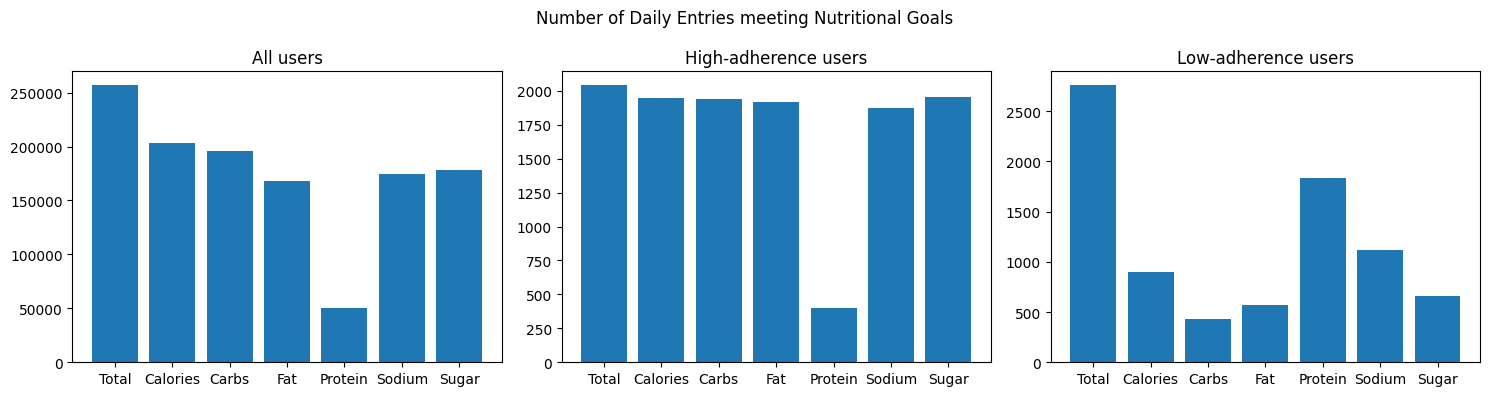

In [21]:
# Create a subplot
fig, axes = plt.subplots(1, 3, figsize=(15,4))

# Plot all users
userGoals = all_users
met_calories = userGoals.calories <= userGoals.goal_calories
met_carbs = userGoals.carbs <= userGoals.goal_carbs
met_fat = userGoals.fat <= userGoals.goal_fat
met_protein = userGoals.protein >= userGoals.goal_protein
met_sodium = userGoals.sodium <= userGoals.goal_sodium
met_sugar = userGoals.sugar <= userGoals.goal_sugar
met_df = pd.DataFrame({'Calories': met_calories, 'Carbs': met_carbs, 'Fat': met_fat, 'Protein': met_protein, 'Sodium': met_sodium,
                       'Sugar': met_sugar})
axes[0].bar(height=[len(met_df), met_df.Calories.sum(), met_df.Carbs.sum(), met_df.Fat.sum(), met_df.Protein.sum(), met_df.Sodium.sum(), met_df.Sugar.sum()],
        x=["Total", "Calories", "Carbs", "Fat", "Protein", "Sodium", "Sugar"])
axes[0].set_title("All users")

# Plot users with at least 40 entries within 10% of goals
userGoals = goals_10
met_calories = userGoals.calories <= userGoals.goal_calories
met_carbs = userGoals.carbs <= userGoals.goal_carbs
met_fat = userGoals.fat <= userGoals.goal_fat
met_protein = -userGoals.protein >= -userGoals.goal_protein
met_sodium = userGoals.sodium <= userGoals.goal_sodium
met_sugar = userGoals.sugar <= userGoals.goal_sugar
met_df = pd.DataFrame({'Calories': met_calories, 'Carbs': met_carbs, 'Fat': met_fat, 'Protein': met_protein, 'Sodium': met_sodium,
                       'Sugar': met_sugar})
axes[1].bar(height=[len(met_df), met_df.Calories.sum(), met_df.Carbs.sum(), met_df.Fat.sum(), met_df.Protein.sum(), met_df.Sodium.sum(), met_df.Sugar.sum()],
        x=["Total", "Calories", "Carbs", "Fat", "Protein", "Sodium", "Sugar"])
axes[1].set_title("High-adherence users")

# Plot users with at least 40 entries within 300% of goals
userGoals = goals_300
met_calories = userGoals.calories <= userGoals.goal_calories
met_carbs = userGoals.carbs <= userGoals.goal_carbs
met_fat = userGoals.fat <= userGoals.goal_fat
met_protein = -userGoals.protein >= -userGoals.goal_protein
met_sodium = userGoals.sodium <= userGoals.goal_sodium
met_sugar = userGoals.sugar <= userGoals.goal_sugar
met_df = pd.DataFrame({'Calories': met_calories, 'Carbs': met_carbs, 'Fat': met_fat, 'Protein': met_protein, 'Sodium': met_sodium,
                       'Sugar': met_sugar})
axes[2].bar(height=[len(met_df), met_df.Calories.sum(), met_df.Carbs.sum(), met_df.Fat.sum(), met_df.Protein.sum(), met_df.Sodium.sum(), met_df.Sugar.sum()],
        x=["Total", "Calories", "Carbs", "Fat", "Protein", "Sodium", "Sugar"])
axes[2].set_title("Low-adherence users")

fig.suptitle("Number of Daily Entries meeting Nutritional Goals")
fig.tight_layout(); fig.show()

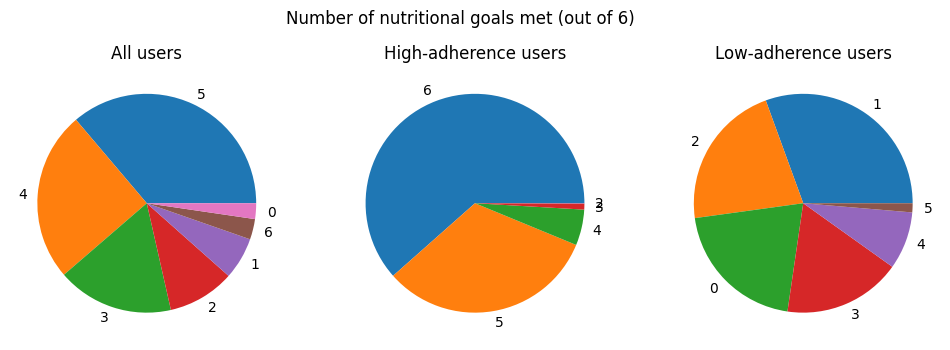

In [22]:
# Create a subplot
fig, axes = plt.subplots(1, 3, figsize=(12,4))

# Plot all users
userGoals = all_users
axes[0].pie(userGoals["num_met"].value_counts().values, labels=userGoals["num_met"].value_counts().index)
axes[0].set_title("All users")

# Plot high-adherence users
userGoals = goals_10
axes[1].pie(userGoals["num_met"].value_counts().values, labels=userGoals["num_met"].value_counts().index)
axes[1].set_title("High-adherence users")

# Plot low-adherence users
userGoals = goals_300
axes[2].pie(userGoals["num_met"].value_counts().values, labels=userGoals["num_met"].value_counts().index)
axes[2].set_title("Low-adherence users")


plt.suptitle("Number of nutritional goals met (out of 6)")
plt.show()

# IO Models

### Archive

In [18]:
def OIO_a(A,b,x):
    # Model Settings
    mod = gp.Model("Objective-Space Model")
    mod.Params.OutputFlag = 0; mod.Params.DualReductions = 0
    mod.Params.timeLimit = 100.00

    # Dimensions
    m = A.shape[0] # m is the number of constraints
    n = A.shape[1] # n is the number of variables
    # Create variables
    c = mod.addVars(n,  lb=-GRB.INFINITY, name = 'c')
    y = mod.addVars(m,  lb=-GRB.INFINITY, name = 'y')
    e = mod.addVars(1,  lb=-GRB.INFINITY, name = 'e')
    t = mod.addVars(1,  lb=-GRB.INFINITY, name = 't')

    # Set objective:
    mod.setObjective(t[0], GRB.MINIMIZE)
    mod.addConstr(t[0] >= e[0])
    mod.addConstr(t[0] >= -e[0])

    # Constraints
    for i in range(n):
        mod.addConstr(gp.quicksum(y[j] * A[j,i] for j in range(m)) == c[i])
    mod.addConstrs(y[j] >= 0 for j in range(m))
    mod.addConstr(gp.quicksum(c[j] * x[j] for j in range(n)) == gp.quicksum(b[i] * y[i] for i in range(m)) + e[0])
    mod.addConstr(gp.quicksum(c[i]  for i in range(n)) == 1)
    mod.params.NonConvex = 2
    mod.optimize()

    Z = np.zeros (n)
    C = np.zeros (n)
    rT = mod.runTime
    # Added in case model is infeasible:
    if mod.status == GRB.OPTIMAL:
        objVal = mod.objVal
        count = 0
        for v in c.values():
            C[count] = v.X
            count += 1
    elif mod.status == GRB.INFEASIBLE:
        print('Model is infeasible')
        objVal = 999
    elif mod.status == GRB.UNBOUNDED:
        print('Model is unbounded')
        objVal = 999
    else:
        print('Optimization ended with status %d' % mod.status)
        if mod.status == 9: rT = 100
        objVal = 999

    return t[0], C, objVal, rT

In [19]:
def DIO_a(A,b,x):
    # Model Settings
    mod = gp.Model("Decision-Space Model")
    mod.Params.OutputFlag = 0; mod.Params.DualReductions = 0
    mod.Params.timeLimit = 100.00

    # Dimensions
    m = A.shape[0] # m is the number of constraints
    n = A.shape[1] # n is the number of variables
    # Create variables
    c = mod.addVars(n,  lb=-GRB.INFINITY, name = 'c')
    y = mod.addVars(m,  lb=-GRB.INFINITY, name = 'y')
    z = mod.addVars(n, name = 'z')
    e = mod.addVars(n,  lb=-GRB.INFINITY, name = 'e')
    t = mod.addVars(n,  lb=-GRB.INFINITY, name = 't')

    # Set objective:
    mod.setObjective(gp.quicksum(t[i] for i in range(n)), GRB.MINIMIZE)
    mod.addConstrs(t[i] >= e[i] for i in range(n))
    mod.addConstrs(t[i] >= -e[i] for i in range(n))
    mod.addConstrs(x[i] - e[i]  == z[i] for i in range(n))
    # Constraints
    for j in range(m):
        mod.addConstr(gp.quicksum(A[j,i] * z[i] for i in range(n)) >= b[j])
    for i in range(n):
        mod.addConstr(gp.quicksum(y[j] * A[j,i] for j in range(m)) == c[i])
    mod.addConstrs(y[j] >= 0 for j in range(m))
    mod.addConstr(gp.quicksum(c[j] * z[j] for j in range(n)) == gp.quicksum(b[i] * y[i] for i in range(m)))
    # mod.addConstr(gp.quicksum(y[j] for j in range(m)) == 1)
    mod.addConstr(gp.quicksum(c[i] for i in range(n)) == 1)
    mod.params.NonConvex = 2
    mod.optimize()

    Z = np.zeros (n)
    C = np.zeros (n)
    rT = mod.runTime
    # Added in case model is infeasible:
    if mod.status == GRB.OPTIMAL:
        objVal = mod.objVal
        count = 0
        for v in z.values():
            Z[count] = v.X
            count += 1
        count = 0
        for v in c.values():
            C[count] = v.X
            count += 1
    elif mod.status == GRB.INFEASIBLE:
        print('Model is infeasible')
        objVal = 999
    elif mod.status == GRB.UNBOUNDED:
        print('Model is unbounded')
        objVal = 999
    else:
        print('Optimization ended with status %d' % mod.status)
        if mod.status == 9: rT = 100
        objVal = 999

    return Z, C, objVal, rT

In [20]:
def CIO_a(A, b, x):
    # Model Settings
    mod = gp.Model("General Bilinear Constraint-Space Model")
    mod.Params.OutputFlag = 0; mod.Params.DualReductions = 0
    mod.Params.timeLimit = 500.00

    # Dimensions
    m = A.shape[0] # m is the number of constraints
    n = A.shape[1]+1 # n is the number of variables

    # Create variables
    c_bar = mod.addVars(n,  lb=-GRB.INFINITY, name = 'c_bar') # Cost vector with additional dimension
    y = mod.addVars(m,  lb=-GRB.INFINITY, name = 'y') # Dual variables
    L = mod.addVars(m, n, lb=-GRB.INFINITY, name = 'Lambda') # Noise decision variables
    V = mod.addVars(m, n, lb=-GRB.INFINITY, name = 'Absolute value Lambda') # Absolute Value of Noise decision variables

    # Add an extra dimension to x and A, to merge LHS and RHS constraint noise
    x_bar = np.append(x, 1)
    A_bar = np.append(A, np.zeros(shape=(m,1)), axis=1)

    #### OBJECTIVE ####
    mod.setObjective(gp.quicksum(V[j,i] for j in range(m) for i in range(n)), GRB.MINIMIZE)
    mod.addConstrs(V[j,i] >= L[j,i] for j in range(m) for i in range(n))
    mod.addConstrs(V[j,i] >= -L[j,i] for j in range(m) for i in range(n))

    #### CONSTRAINTS ####
    ## Main constraints ##
    # Primal Feasibility
    for j in range(m):
        mod.addConstr(gp.quicksum((A_bar[j,i] - L[j,i]) * x_bar[i] for i in range(n)) >= b[j])
    # Dual Feasibility
    for i in range(n):
        mod.addConstr(gp.quicksum((A_bar[j,i] - L[j,i])* y[j] for j in range(m)) == c_bar[i])
    mod.addConstrs(y[j] >= 0 for j in range(m))
    # Strong duality
    mod.addConstr(gp.quicksum(c_bar[j] * x_bar[j] for j in range(n)) == gp.quicksum(b[i] * y[i] for i in range(m)))
    # Norm of c
    mod.addConstr(gp.quicksum(c_bar[i]  for i in range(n-1)) == 1)
    ## Side constraints ##
    # Non-negativity of adjusted nutritional values
    for i in range(n):
        for j in range(m):
            mod.addConstr(A_bar[j,i] - L[j,i] >= 0)

    # Translate non-convex quadratic constraints into bilinear form and apply spatial branching
    mod.params.NonConvex = 2
    # Optimize
    mod.optimize()

    # Get optimization results
    obj = 9999
    rT = mod.runTime
    Lambda = np.empty(shape=(m,n))
    cost = np.empty(shape=(n,1))
    tConstrs = []

    if mod.status == GRB.OPTIMAL:
        obj = mod.ObjVal
        for v in mod.getVars():
            for i in range(n):
                if v.VarName == 'c_bar['+str(i)+']': cost[i] = v.X
                for j in range(m):
                    if v.VarName == 'Lambda['+str(j)+','+str(i)+']': Lambda[j,i] = v.X
        j = 0
        # TODO: Verify that this matches tight constraints
        for v in y.values():
            if v.X == 0: tConstrs.append(j)
            j += 1
    elif mod.status == GRB.INFEASIBLE:
        print('Model is infeasible')
    elif mod.status == GRB.UNBOUNDED:
        print('Model is unbounded')
    else:
        print('Optimization ended with status %d' % mod.status)

    return Lambda, cost, obj, rT, tConstrs

In [21]:
def CIO(A, b, X):
    # Model Settings
    mod = gp.Model("General Bilinear Constraint-Space Model")
    mod.Params.OutputFlag = 0; mod.Params.DualReductions = 0
    mod.Params.timeLimit = 180.00

    # Dimensions
    m = A.shape[0] # m is the number of constraints
    n = A.shape[1]+1 # n is the number of variables
    q = X.shape[0] # q is the number of observations

    # Create variables
    c_bar = mod.addVars(n,  lb=-GRB.INFINITY, name = 'c_bar') # Cost vector with additional dimension
    y = mod.addVars(q, m,  lb=-GRB.INFINITY, name = 'y') # Dual variables
    L = mod.addVars(m, n, lb=-GRB.INFINITY, name = 'Lambda') # Noise decision variables
    V = mod.addVars(m, n, lb=-GRB.INFINITY, name = 'Absolute value Lambda') # Absolute Value of Noise decision variables
    Z = mod.addVars(q, n, name = 'Z')
    # Z = mod.addVars(n, name='Z')
    E = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'E')
    D = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'D')
    w = mod.addVar(lb=0)

    # Add an extra dimension to X and A, to merge LHS and RHS constraint noise
    X_bar = np.append(X, np.ones(shape=(q,1)), axis=1)
    A_bar = np.append(A, np.zeros(shape=(m,1)), axis=1)

    #### OBJECTIVE ####
    mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n)), GRB.MINIMIZE)
    # mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n)) + gp.quicksum(V[j,i] for j in range(m) for i in range(n)), GRB.MINIMIZE)
    # mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n)) + gp.quicksum(V[j,i] for j in range(m) for i in range(n)), GRB.MINIMIZE)
    mod.addConstrs(V[j,i] >= L[j,i] for j in range(m) for i in range(n))
    mod.addConstrs(V[j,i] >= -L[j,i] for j in range(m) for i in range(n))
    mod.addConstrs(D[k,i] >= E[k,i] for k in range(q) for i in range(n))
    mod.addConstrs(D[k,i] >= -E[k,i] for k in range(q) for i in range(n))
    mod.addConstrs(Z[k,i] >= X_bar[k,i] - E[k,i] for k in range(q) for i in range(n))
    mod.addConstrs(Z[k,i] <= -X_bar[k,i] + E[k,i] for k in range(q) for i in range(n))

    #### CONSTRAINTS ####
    ## Main constraints ##
    # Primal Feasibility
    for k in range(q):
        for j in range(m):
            mod.addConstr(gp.quicksum((A_bar[j,i] - L[j,i]) * Z[k,i] for i in range(n)) >= b[j])
    # Dual Feasibility
    for i in range(n):
        mod.addConstr(gp.quicksum((A_bar[j,i] - L[j,i])* y[k,j] for j in range(m)) == c_bar[i])
    mod.addConstrs(y[j] >= 0 for j in range(m))
    # Strong duality
    mod.addConstr(gp.quicksum(c_bar[j] * Z[k,j] for j in range(n)) == gp.quicksum(b[i] * y[i] for i in range(m)))
    # Norm of c
    mod.addConstr(gp.quicksum(c_bar[i]  for i in range(n-1)) == 1)
    ## Side constraints ##
    # Non-negativity of adjusted nutritional values
    for i in range(n):
        for j in range(m):
            mod.addConstr(A_bar[j,i] - L[j,i] >= 0)
            # Limit nutrient adjustment to +/-50% of original value
            mod.addConstr(V[j,i] <= 0.5*A_bar[j,i])

    # Translate non-convex quadratic constraints into bilinear form and apply spatial branching
    mod.params.NonConvex = 2
    # Optimize
    mod.optimize()

    # Get optimization results
    obj = 9999
    rT = mod.runTime
    Lambda = np.empty(shape=(m,n))
    X_new = np.empty(shape=X.shape)
    cost = np.empty(shape=(n,))
    tConstrs = []


    if mod.status == GRB.OPTIMAL:
        obj = mod.ObjVal
        for v in mod.getVars():
            for i in range(n):
                for j in range(m):
                    if v.VarName == 'Lambda['+str(j)+','+str(i)+']': Lambda[j,i] = v.X
            for k in range(q):
                for i in range(n-1):
                    if v.VarName == 'c_bar['+str(i)+']': cost[i] = v.X
                    if v.VarName == 'Z[' +str(k)+','+str(i)+']': X_new[k,i] = v.X
        j = 0
        # TODO: Verify that this matches tight constraints
        for v in y.values():
            if v.X == 0: tConstrs.append(j)
            j += 1
    elif mod.status == GRB.INFEASIBLE:
        print('Model is infeasible')
    elif mod.status == GRB.UNBOUNDED:
        print('Model is unbounded')
    else:
        print('Optimization ended with status %d' % mod.status)

    return Lambda, X_new, 10, cost, obj, rT, tConstrs

In [25]:
def IL(A, b, X):
    # Model Settings
    mod = gp.Model("General Bilinear Constraint-Space Model")
    mod.Params.OutputFlag = 0; mod.Params.DualReductions = 0
    mod.Params.timeLimit = 200.00

    # Dimensions
    m = A.shape[0] # m is the number of constraints
    n = A.shape[1]+1 # n is the number of variables
    q = X.shape[0] # q is the number of observations

    # Create variables
    c_bar = mod.addVars(n,  lb=-GRB.INFINITY, name = 'c_bar') # Cost vector with additional dimension
    y = mod.addVars(m,  lb=-GRB.INFINITY, name = 'y') # Dual variables
    Z = mod.addVars(n, name = 'Z')
    E = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'E')
    D = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'D')
    w = mod.addVar(lb=0)

    # Add an extra dimension to X and A, to merge LHS and RHS constraint noise
    X_bar = np.append(X, np.ones(shape=(q,1)), axis=1)
    A_bar = np.append(A, np.zeros(shape=(m,1)), axis=1)

    #### OBJECTIVE ####
    mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n)), GRB.MINIMIZE)
    # mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n)) + gp.quicksum(V[j,i] for j in range(m) for i in range(n)), GRB.MINIMIZE)
    # mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n)) + gp.quicksum(V[j,i] for j in range(m) for i in range(n)), GRB.MINIMIZE)
    mod.addConstrs(D[k,i] >= E[k,i] for k in range(q) for i in range(n))
    mod.addConstrs(D[k,i] >= -E[k,i] for k in range(q) for i in range(n))
    mod.addConstrs(Z[i] >= X_bar[k,i] - E[k,i] for k in range(q) for i in range(n))
    mod.addConstrs(Z[i] <= -X_bar[k,i] + E[k,i] for k in range(q) for i in range(n))

    #### CONSTRAINTS ####
    ## Main constraints ##
    # Primal Feasibility
    for j in range(m):
        mod.addConstr(gp.quicksum((A_bar[j,i]) * Z[i] for i in range(n)) >= b[j])
    # Dual Feasibility
    for i in range(n):
        mod.addConstr(gp.quicksum((A_bar[j,i])* y[j] for j in range(m)) == c_bar[i])
    mod.addConstrs(y[j] >= 0 for j in range(m))
    # Strong duality
    mod.addConstr(gp.quicksum(c_bar[j] * Z[j] for j in range(n)) == gp.quicksum(b[i] * y[i] for i in range(m)))
    # Norm of c
    mod.addConstr(gp.quicksum(c_bar[i]  for i in range(n-1)) == 1)

    # Translate non-convex quadratic constraints into bilinear form and apply spatial branching
    mod.params.NonConvex = 2
    # Optimize
    mod.optimize()

    # Get optimization results
    obj = 9999
    rT = mod.runTime
    Lambda = np.empty(shape=(m,n))
    rec = np.empty(shape=(n,1))
    cost = np.empty(shape=(n,1))
    tConstrs = []


    if mod.status == GRB.OPTIMAL:
        obj = mod.ObjVal
        for v in mod.getVars():
            for i in range(n):
                if v.VarName == 'c_bar['+str(i)+']': cost[i] = v.X
                if v.VarName == 'Z['+str(i)+']': rec[i] = v.X
        j = 0
        # TODO: Verify that this matches tight constraints
        for v in y.values():
            if v.X == 0: tConstrs.append(j)
            j += 1
    elif mod.status == GRB.INFEASIBLE:
        print('Model is infeasible')
    elif mod.status == GRB.UNBOUNDED:
        print('Model is unbounded')
    else:
        print('Optimization ended with status %d' % mod.status)

    return 0, rec, 0, cost, obj, rT, tConstrs

In [24]:
def CIO_IL_Multi(A, b, X):
    # Model Settings
    mod = gp.Model("General Bilinear Constraint-Space Model")
    mod.Params.OutputFlag = 0; mod.Params.DualReductions = 0
    mod.Params.timeLimit = 1000.00

    # Dimensions
    m = A.shape[0] # m is the number of constraints
    n = A.shape[1]+1 # n is the number of variables
    q = X.shape[0] # q is the number of observations

    # Create variables
    c_bar = mod.addVars(n,  lb=-GRB.INFINITY, name = 'c_bar') # Cost vector with additional dimension
    y = mod.addVars(m,  lb=-GRB.INFINITY, name = 'y') # Dual variables
    L = mod.addVars(m, n, lb=-GRB.INFINITY, name = 'Lambda') # Noise decision variables
    V = mod.addVars(m, n, lb=-GRB.INFINITY, name = 'Absolute value Lambda') # Absolute Value of Noise decision variables
    Z = mod.addVars(n, name = 'Z')
    # Z = mod.addVars(n, name='Z')
    E = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'E')
    D = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'D')
    w = mod.addVar(lb=0)

    # Add an extra dimension to X and A, to merge LHS and RHS constraint noise
    X_bar = np.append(X, np.ones(shape=(q,1)), axis=1)
    A_bar = np.append(A, np.zeros(shape=(m,1)), axis=1)

    #### OBJECTIVE ####
    mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n)), GRB.MINIMIZE)
    # mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n)) + gp.quicksum(V[j,i] for j in range(m) for i in range(n)), GRB.MINIMIZE)
    # mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n)) + gp.quicksum(V[j,i] for j in range(m) for i in range(n)), GRB.MINIMIZE)
    mod.addConstrs(V[j,i] >= L[j,i] for j in range(m) for i in range(n))
    mod.addConstrs(V[j,i] >= -L[j,i] for j in range(m) for i in range(n))
    mod.addConstrs(D[k,i] >= E[k,i] for k in range(q) for i in range(n))
    mod.addConstrs(D[k,i] >= -E[k,i] for k in range(q) for i in range(n))
    mod.addConstrs(Z[i] >= X_bar[k,i] - E[k,i] for k in range(q) for i in range(n))
    mod.addConstrs(Z[i] <= -X_bar[k,i] + E[k,i] for k in range(q) for i in range(n))

    #### CONSTRAINTS ####
    ## Main constraints ##
    # Primal Feasibility
    for j in range(m):
        mod.addConstr(gp.quicksum((A_bar[j,i] - L[j,i]) * Z[i] for i in range(n)) <= b[j])
    # Dual Feasibility
    for i in range(n):
        mod.addConstr(gp.quicksum((A_bar[j,i] - L[j,i])* y[j] for j in range(m)) == c_bar[i])
    mod.addConstrs(y[j] >= 0 for j in range(m))
    # Strong duality
    mod.addConstr(gp.quicksum(c_bar[j] * Z[j] for j in range(n)) == gp.quicksum(b[i] * y[i] for i in range(m)))
    # Norm of c
    mod.addConstr(gp.quicksum(c_bar[i]  for i in range(n-1)) == 1)
    ## Side constraints ##
    # Non-negativity of adjusted nutritional values
    for i in range(n):
        for j in range(m):
            mod.addConstr(A_bar[j,i] - L[j,i] >= 0)
            # Limit nutrient adjustment to +/-50% of original value
            mod.addConstr(V[j,i] <= 0.5*A_bar[j,i])

    # Translate non-convex quadratic constraints into bilinear form and apply spatial branching
    mod.params.NonConvex = 2
    # Optimize
    mod.optimize()

    # Get optimization results
    obj = 9999
    rT = mod.runTime
    Lambda = np.empty(shape=(m,n))
    rec = np.empty(shape=(n,1))
    cost = np.empty(shape=(n,1))
    tConstrs = []


    if mod.status == GRB.OPTIMAL:
        obj = mod.ObjVal
        for v in mod.getVars():
            for i in range(n):
                if v.VarName == 'c_bar['+str(i)+']': cost[i] = v.X
                for j in range(m):
                    if v.VarName == 'Lambda['+str(j)+','+str(i)+']': Lambda[j,i] = v.X
                if v.VarName == 'Z['+str(i)+']': rec[i] = v.X
        j = 0
        # TODO: Verify that this matches tight constraints
        for v in y.values():
            if v.X == 0: tConstrs.append(j)
            j += 1
    elif mod.status == GRB.INFEASIBLE:
        print('Model is infeasible')
    elif mod.status == GRB.UNBOUNDED:
        print('Model is unbounded')
    else:
        print('Optimization ended with status %d' % mod.status)

    return Lambda, rec, 10, cost, obj, rT, tConstrs

In [23]:
def IO_one_observation(A,b,X):
    m1 = A.shape[0]
    n = A.shape[1]
    AT = A.T
    num_var = 2 * n + 3 * n + m1
    e = gp.Env(empty=True)
    e.setParam('WLSACCESSID', 'aee9347f-b4d4-4058-a8c2-a0c6954ea740')
    e.setParam('WLSSECRET', '30cef1f9-9233-48a0-a138-9d092ef2ce32')
    e.setParam('LICENSEID', 862033)
    e.start()
    m = gp.Model("IO",env=e)
    #m.Params.timeLimit = 100.0
    m.Params.OutputFlag = 0
    # Create variables
    e = m.addVars(n,  lb=-GRB.INFINITY, name = 'e')
    t = m.addVars(n,  lb=-GRB.INFINITY, name = 't')
    c = m.addVars(n,  lb=-GRB.INFINITY, name = 'c')
    y = m.addVars(m1,  lb=-GRB.INFINITY, name = 'y')
    d = m.addVars(n,  lb=-GRB.INFINITY, name = 'd')
    z = m.addVars(n, ub =2, name = 'z')
    #z = m.addVars(n, ub =6, vtype=gp.GRB.INTEGER, name = 'z')
    # Set objective:
    m.setObjective(gp.quicksum(t[i] for i in range(n)), GRB.MINIMIZE)
    # Constraints
    m.addConstrs(t[i] >= e[i] for i in range(n))
    m.addConstrs(t[i] >= -e[i] for i in range(n))
    m.addConstrs(X[i] - e[i]  == z[i] for i in range(n))
    for j in range(m1):
        m.addConstr(gp.quicksum(A[j,i] * z[i] for i in range(n)) <= b[j])
    for i in range(n):
        m.addConstr(gp.quicksum(y[j] * A[j,i] for j in range(m1)) == c[i])    
    m.addConstrs(y[j] >= 0 for j in range(m1))
    m.addConstr(gp.quicksum(c[j] * z[j] for j in range(n)) == gp.quicksum(b[i] * y[i] for i in range(m1)))
    #for i in range(n):
    #    m.addConstr(d[i] == gp.abs_(c[i]))
    #m.addConstr(gp.quicksum(d[i] for i in range(n)) == 1) 
    m.addConstr(gp.quicksum(y[j]  for j in range(m1)) == 1)
    #m.addConstr(z[14] == 0) #no_egg_omelette_substitute
    #m.addConstr(z[26] == 0) #no_meat_substitute
    m.params.NonConvex = 2   
    m.optimize()
    vars = m.getVars()
    #for i in range (n):
    #    print (vars [num_var -1 -(n-1-i)])
#     n = A.shape[1]
    Z = np.zeros (n)
    C = np.zeros (n)
    count = 0
    for v in z.values():
        Z[count] = v.X
        count += 1
    count = 0
    for v in c.values():
        C[count] = v.X
        count += 1
    return Z, C

### In-Use

In [84]:
def IL(A, b, X):
    # Model Settings
    mod = gp.Model("General Bilinear Constraint-Space Model")
    mod.Params.OutputFlag = 0; mod.Params.DualReductions = 0
    mod.Params.timeLimit = 200.00

    # Dimensions
    m = A.shape[0] # m is the number of constraints
    n = A.shape[1] # n is the number of variables
    q = X.shape[0] # q is the number of observations

    # Create variables
    c = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'c') # Cost vector with additional dimension
    y = mod.addVars(q, m,  lb=-GRB.INFINITY, name = 'y') # Dual variables
    Z = mod.addVars(q, n, name = 'Z')
    E = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'E')
    D = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'D')

    #### OBJECTIVE ####
    mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n))/q, GRB.MINIMIZE)
    
    #### CONSTRAINTS ####
    ## Main constraints ##
    # Primal Feasibility
    for k in range(q):
        for j in range(m):
            mod.addConstr(gp.quicksum(A[j,i] * Z[k,i] for i in range(n)) <= b[j])
    # Dual Feasibility
    for k in range(q):
        for i in range(n):
            mod.addConstr(gp.quicksum(A[j,i]* y[k,j] for j in range(m)) == c[k,i])
    mod.addConstrs(y[k,j] >= 0 for j in range(m) for k in range(q))
    # Strong duality
    for k in range(q):
        mod.addConstr(gp.quicksum(c[k, j] * Z[k,j] for j in range(n)) == gp.quicksum(b[i] * y[k, i] for i in range(m)))
    # Norm of y
    for k in range(q):
        mod.addConstr(gp.quicksum(y[k, j] for j in range(m)) == 1)
    
    ## Side constraints ##
    # Recommendations vs Observations
    mod.addConstrs(Z[k,i] == (X[k,i] - E[k,i]) for k in range(q) for i in range(n))
    for i in range(n):
        # Non-negativity of recommendations
        mod.addConstrs(Z[k,i] >= 0 for j in range(m) for k in range(q))
        # Normalize distance metric to current observation
        for k in range(q):
            mod.addConstr(D[k,i] >= E[k,i])
            mod.addConstr(D[k,i] >= -E[k,i])
    
    # Limit total number of food items patient can eat
    # mod.addConstrs(gp.quicksum(Z[k,i] for i in range(n)) <= 20  for k in range(q))

    # Translate non-convex quadratic constraints into bilinear form and apply spatial branching
    mod.params.NonConvex = 2
    # Optimize
    mod.optimize()

    # Get optimization results
    obj = 9999
    rT = mod.runTime
    AbsError = np.empty(shape=X.shape)
    AbsE = np.empty(q)
    X_new = np.empty(shape=X.shape)
    cost = np.empty(shape=(q,n))


    if mod.status == GRB.OPTIMAL:
        obj = mod.ObjVal
        print("Optimization complete, objective value: ", obj)
        for v in mod.getVars():
            for k in range(q):
                for i in range(n):
                    if v.VarName == 'c['+str(i)+']': cost[k,i] = v.X
                    if v.VarName == 'Z[' +str(k)+','+str(i)+']': X_new[k,i] = v.X
                    if v.VarName == 'D[' +str(k)+','+str(i)+']': AbsError[k,i] = v.X # if k == 0: print(v.VarName, v.X)
        for k in range(q):
            AbsE[k] = np.sum(AbsError[k]) 

    elif mod.status == GRB.INFEASIBLE:
        print('Model is infeasible')
    elif mod.status == GRB.UNBOUNDED:
        print('Model is unbounded')
    else:
        print('Optimization ended with status %d' % mod.status)

    return X_new, AbsE, cost, obj, rT

In [93]:
def IL_1c(A, b, X):
    # Model Settings
    mod = gp.Model("General Bilinear Constraint-Space Model")
    mod.Params.OutputFlag = 0; mod.Params.DualReductions = 0
    mod.Params.timeLimit = 200.00

    # Dimensions
    m = A.shape[0] # m is the number of constraints
    n = A.shape[1] # n is the number of variables
    q = X.shape[0] # q is the number of observations

    # Create variables
    c = mod.addVars(n,  lb=-GRB.INFINITY, name = 'c') # Cost vector with additional dimension
    y = mod.addVars(m,  lb=-GRB.INFINITY, name = 'y') # Dual variables
    Z = mod.addVars(q, n, name = 'Z')
    E = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'E')
    D = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'D')

    #### OBJECTIVE ####
    mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n))/q, GRB.MINIMIZE)
    
    #### CONSTRAINTS ####
    ## Main constraints ##
    # Primal Feasibility
    for k in range(q):
        for j in range(m):
            mod.addConstr(gp.quicksum(A[j,i] * Z[k,i] for i in range(n)) <= b[j])
    # Dual Feasibility
    for i in range(n):
        mod.addConstr(gp.quicksum(A[j,i]* y[j] for j in range(m)) == c[i])
    mod.addConstrs(y[j] >= 0 for j in range(m) for k in range(q))
    # Strong duality
    for k in range(q):
        mod.addConstr(gp.quicksum(c[j] * Z[k,j] for j in range(n)) == gp.quicksum(b[i] * y[i] for i in range(m)))
    # Norm of y
    mod.addConstr(gp.quicksum(y[j] for j in range(m)) == 1)
    
    ## Side constraints ##
    # Recommendations vs Observations
    mod.addConstrs(Z[k,i] == (X[k,i] - E[k,i]) for k in range(q) for i in range(n))
    for i in range(n):
        # Non-negativity of recommendations
        mod.addConstrs(Z[k,i] >= 0 for j in range(m) for k in range(q))
        # Normalize distance metric to current observation
        for k in range(q):
            mod.addConstr(D[k,i] >= E[k,i])
            mod.addConstr(D[k,i] >= -E[k,i])
    
    # Limit total number of food items patient can eat
    # mod.addConstrs(gp.quicksum(Z[k,i] for i in range(n)) <= 20  for k in range(q))

    # Translate non-convex quadratic constraints into bilinear form and apply spatial branching
    mod.params.NonConvex = 2
    # Optimize
    mod.optimize()

    # Get optimization results
    obj = 9999
    rT = mod.runTime
    AbsError = np.empty(shape=X.shape)
    AbsE = np.empty(q)
    X_new = np.empty(shape=X.shape)
    cost = np.empty(n)


    if mod.status == GRB.OPTIMAL:
        obj = mod.ObjVal
        print("Optimization complete, objective value: ", obj)
        for v in mod.getVars():
            for k in range(q):
                for i in range(n):
                    if v.VarName == 'c['+str(i)+']': cost[i] = v.X
                    if v.VarName == 'Z[' +str(k)+','+str(i)+']': X_new[k,i] = v.X
                    if v.VarName == 'D[' +str(k)+','+str(i)+']': AbsError[k,i] = v.X # if k == 0: print(v.VarName, v.X)
        for k in range(q):
            AbsE[k] = np.sum(AbsError[k]) 

    elif mod.status == GRB.INFEASIBLE:
        print('Model is infeasible')
    elif mod.status == GRB.UNBOUNDED:
        print('Model is unbounded')
    else:
        print('Optimization ended with status %d' % mod.status)

    return X_new, AbsE, cost, obj, rT

In [60]:
def CDH_IL(A, b, X, w):
    # Model Settings
    mod = gp.Model("General Bilinear Constraint-Space Model")
    mod.Params.OutputFlag = 0; mod.Params.DualReductions = 0; mod.Params.MIPGap = 0.01
    mod.Params.timeLimit = 2000.00

    # Dimensions
    m = A.shape[0] # m is the number of constraints
    n = A.shape[1]+1 # n is the number of variables
    q = X.shape[0] # q is the number of observations

    # Create variables
    c_bar = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'c_bar') # Cost vector with additional dimension
    y = mod.addVars(q, m,  lb=-GRB.INFINITY, name = 'y') # Dual variables
    L = mod.addVars(m, n, lb=-GRB.INFINITY, name = 'Lambda') # Noise decision variables
    T = mod.addVars(n, vtype=GRB.BINARY)
    V = mod.addVars(m, n, lb=-GRB.INFINITY, name = 'Absolute value Lambda') # Absolute Value of Noise decision variables
    Z = mod.addVars(q, n, name = 'Z')
    E = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'E')
    D = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'D')

    # Add an extra dimension to X and A, to merge LHS and RHS constraint noise
    X_bar = np.append(X, np.ones(shape=(q,1)), axis=1)
    A_bar = np.append(A, np.zeros(shape=(m,1)), axis=1)

    #### OBJECTIVE ####
    mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n))/q, GRB.MINIMIZE)
    
    #### CONSTRAINTS ####
    ## Main constraints ##
    # Primal Feasibility
    for k in range(q):
        for j in range(m):
            mod.addConstr(gp.quicksum((A_bar[j,i] - L[j,i]) * Z[k,i] for i in range(n)) <= b[j])
    # Dual Feasibility
    for k in range(q):
        for i in range(n):
            mod.addConstr(gp.quicksum((A_bar[j,i] - L[j,i])* y[k,j] for j in range(m)) == c_bar[k,i])
    mod.addConstrs(y[k,j] >= 0 for j in range(m) for k in range(q))
    # Strong duality
    for k in range(q):
        mod.addConstr(gp.quicksum(c_bar[k, j] * Z[k,j] for j in range(n)) == gp.quicksum(b[i] * y[k, i] for i in range(m)))
    # Norm of y
    for k in range(q):
        mod.addConstr(gp.quicksum(y[k, j] for j in range(m)) == 1)
    
    ## Side constraints ##
    # Absolute Values
    mod.addConstrs(V[j,i] >= L[j,i] for j in range(m) for i in range(n))
    mod.addConstrs(V[j,i] >= -L[j,i] for j in range(m) for i in range(n))
    mod.addConstrs(Z[k,i] == (X_bar[k,i] - E[k,i]) for k in range(q) for i in range(n))
    # No RHS adjustement
    mod.addConstrs(L[j,n-1] == 0 for j in range(m))
    # Limit number of food items with flexible constraints
    mod.addConstr(gp.quicksum(T[i] for i in range(n)) <= 3)
    # No RHS constraint adjustement
    mod.addConstrs(V[j,n-1] == 0 for j in range(m))
    for i in range(n):
        # Non-negativity of recommendations
        mod.addConstrs(Z[k,i] >= 0 for j in range(m) for k in range(q))
        # Normalize distance metric to current observation
        for k in range(q):
            if X_bar[k,i]!=0:
                mod.addConstr(D[k,i] >= E[k,i]/X_bar[k,i])
                mod.addConstr(D[k,i] >= -E[k,i]/X_bar[k,i])
            else:
                mod.addConstr(D[k,i] >= E[k,i])
                mod.addConstr(D[k,i] >= -E[k,i])
        for j in range(int(m/2)):
            # Non-negativity of adjusted nutritional values
            mod.addConstr(A_bar[j,i] - L[j,i] >= 0)
            # Limit nutrient adjustment to +/-w% of original value
            mod.addConstr(V[j,i] <= w*A_bar[j,i]*T[i]) # mod.addConstr(V[j,i] <= 0.1*A_bar[j,i]*T[i])
        for j in range(int(m/2), m):
            # Non-negativity of adjusted nutritional values
            mod.addConstr(A_bar[j,i] - L[j,i] <= 0)
            # Limit nutrient adjustment to +/-w% of original value
            mod.addConstr(V[j,i] <= -w*A_bar[j,i]*T[i]) # mod.addConstr(V[j,i] <= -0.1*A_bar[j,i]*T[i])
    
    # Limit total number of food items patient can eat
    # mod.addConstrs(gp.quicksum(Z[k,i] for i in range(n)) <= 20  for k in range(q))

    # Translate non-convex quadratic constraints into bilinear form and apply spatial branching
    mod.params.NonConvex = 2
    # Optimize
    mod.optimize()

    # Get optimization results
    obj = 9999
    rT = mod.runTime
    Lambda = np.empty(shape=(m,n))
    AbsError = np.empty(shape=X.shape)
    AbsE = np.empty(q)
    X_new = np.empty(shape=X.shape)
    cost = np.empty(shape=(q,n))


    if mod.status == GRB.OPTIMAL:
        obj = mod.ObjVal
        print("Optimization complete, objective value: ", obj)
        for v in mod.getVars():
            for i in range(n):
                for j in range(m):
                    if v.VarName == 'Lambda['+str(j)+','+str(i)+']': Lambda[j,i] = v.X
            for k in range(q):
                for i in range(n-1):
                    if v.VarName == 'c_bar['+str(i)+']': cost[k,i] = v.X
                    if v.VarName == 'Z[' +str(k)+','+str(i)+']': X_new[k,i] = v.X
                    if v.VarName == 'D[' +str(k)+','+str(i)+']': AbsError[k,i] = v.X # if k == 0: print(v.VarName, v.X)
        for k in range(q):
            AbsE[k] = np.sum(AbsError[k]) 

    elif mod.status == GRB.INFEASIBLE:
        print('Model is infeasible')
    elif mod.status == GRB.UNBOUNDED:
        print('Model is unbounded')
    else:
        print('Optimization ended with status %d' % mod.status)

    return Lambda, X_new, AbsE, cost, obj, rT

In [115]:
def CDH_IL1c(A, b, X, w):
    # Model Settings
    mod = gp.Model("General Bilinear Constraint-Space Model")
    mod.Params.OutputFlag = 0; mod.Params.DualReductions = 0; mod.Params.MIPGap = 0.01
    mod.Params.timeLimit = 100000.00

    # Dimensions
    m = A.shape[0] # m is the number of constraints
    n = A.shape[1]+1 # n is the number of variables
    q = X.shape[0] # q is the number of observations

    # Create variables
    c_bar = mod.addVars(n,  lb=-GRB.INFINITY, name = 'c_bar') # Cost vector with additional dimension
    y = mod.addVars(m,  lb=-GRB.INFINITY, name = 'y') # Dual variables
    L = mod.addVars(m, n, lb=-GRB.INFINITY, name = 'Lambda') # Noise decision variables
    T = mod.addVars(n, vtype=GRB.BINARY)
    V = mod.addVars(m, n, lb=-GRB.INFINITY, name = 'Absolute value Lambda') # Absolute Value of Noise decision variables
    Z = mod.addVars(q, n, name = 'Z')
    E = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'E')
    D = mod.addVars(q, n,  lb=-GRB.INFINITY, name = 'D')

    # Add an extra dimension to X and A, to merge LHS and RHS constraint noise
    X_bar = np.append(X, np.ones(shape=(q,1)), axis=1)
    A_bar = np.append(A, np.zeros(shape=(m,1)), axis=1)

    #### OBJECTIVE ####
    mod.setObjective(gp.quicksum(D[k,i] for k in range(q) for i in range(n))/q, GRB.MINIMIZE)
    
    #### CONSTRAINTS ####
    ## Main constraints ##
    # Primal Feasibility
    for k in range(q):
        for j in range(m):
            mod.addConstr(gp.quicksum((A_bar[j,i] - L[j,i]) * Z[k,i] for i in range(n)) <= b[j])
    # Dual Feasibility
    for k in range(q):
        for i in range(n):
            mod.addConstr(gp.quicksum((A_bar[j,i] - L[j,i])* y[j] for j in range(m)) == c_bar[i])
    mod.addConstrs(y[j] >= 0 for j in range(m))
    # Strong duality
    for k in range(q):
        mod.addConstr(gp.quicksum(c_bar[j] * Z[k,j] for j in range(n)) == gp.quicksum(b[i] * y[i] for i in range(m)))
    # Norm of y
    for k in range(q):
        mod.addConstr(gp.quicksum(y[j] for j in range(m)) == 1)
    
    ## Side constraints ##
    # Absolute Values
    mod.addConstrs(V[j,i] >= L[j,i] for j in range(m) for i in range(n))
    mod.addConstrs(V[j,i] >= -L[j,i] for j in range(m) for i in range(n))
    mod.addConstrs(Z[k,i] == (X_bar[k,i] - E[k,i]) for k in range(q) for i in range(n))
    # No RHS adjustement
    mod.addConstrs(L[j,n-1] == 0 for j in range(m))
    # Limit number of food items with flexible constraints
    mod.addConstr(gp.quicksum(T[i] for i in range(n)) <= 3)
    # No RHS constraint adjustement
    mod.addConstrs(V[j,n-1] == 0 for j in range(m))
    for i in range(n):
        # Non-negativity of recommendations
        mod.addConstrs(Z[k,i] >= 0 for j in range(m) for k in range(q))
        # Normalize distance metric to current observation
        for k in range(q):
            if X_bar[k,i]!=0:
                mod.addConstr(D[k,i] >= E[k,i]/X_bar[k,i])
                mod.addConstr(D[k,i] >= -E[k,i]/X_bar[k,i])
            else:
                mod.addConstr(D[k,i] >= E[k,i])
                mod.addConstr(D[k,i] >= -E[k,i])
        for j in range(int(m/2)):
            # Non-negativity of adjusted nutritional values
            mod.addConstr(A_bar[j,i] - L[j,i] >= 0)
            # Limit nutrient adjustment to +/-w% of original value
            mod.addConstr(V[j,i] <= w*A_bar[j,i]*T[i]) # mod.addConstr(V[j,i] <= 0.1*A_bar[j,i]*T[i])
        for j in range(int(m/2), m):
            # Non-negativity of adjusted nutritional values
            mod.addConstr(A_bar[j,i] - L[j,i] <= 0)
            # Limit nutrient adjustment to +/-w% of original value
            mod.addConstr(V[j,i] <= -w*A_bar[j,i]*T[i]) # mod.addConstr(V[j,i] <= -0.1*A_bar[j,i]*T[i])
    
    # Limit total number of food items patient can eat
    # mod.addConstrs(gp.quicksum(Z[k,i] for i in range(n)) <= 20  for k in range(q))

    # Translate non-convex quadratic constraints into bilinear form and apply spatial branching
    mod.params.NonConvex = 2
    # Optimize
    mod.optimize()

    # Get optimization results
    obj = 9999
    rT = mod.runTime
    Lambda = np.empty(shape=(m,n))
    AbsError = np.empty(shape=X.shape)
    AbsE = np.empty(q)
    X_new = np.empty(shape=X.shape)
    cost = np.empty(n)


    if mod.status == GRB.OPTIMAL:
        obj = mod.ObjVal
        print("Optimization complete, objective value: ", obj)
        for v in mod.getVars():
            for i in range(n):
                for j in range(m):
                    if v.VarName == 'Lambda['+str(j)+','+str(i)+']': Lambda[j,i] = v.X
            for k in range(q):
                for i in range(n-1):
                    if v.VarName == 'c_bar['+str(i)+']': cost[i] = v.X
                    if v.VarName == 'Z[' +str(k)+','+str(i)+']': X_new[k,i] = v.X
                    if v.VarName == 'D[' +str(k)+','+str(i)+']': AbsError[k,i] = v.X # if k == 0: print(v.VarName, v.X)
        for k in range(q):
            AbsE[k] = np.sum(AbsError[k]) 

    elif mod.status == GRB.INFEASIBLE:
        print('Model is infeasible')
    elif mod.status == GRB.UNBOUNDED:
        print('Model is unbounded')
    else:
        print('Optimization ended with status %d' % mod.status)

    return Lambda, X_new, AbsE, cost, obj, rT

# First Examples

### User 1: Day 82 (all goals met)

In [ ]:
userID = 1; day = 82
A, b, x, food_names = get_model_params(userID, day, users, raw_foods, False)

9 foods eaten, b: (6,), [2278.  285.   76. -114. 2300.   85.]


In [ ]:
Z, C_DIO_a, Obj, rT = DIO_a(A, b, x)
print("Day " + str(int(day)) + " DIO_a objective: " + str(Obj))
A_new, b_new, best_i, C_CIO_a, Obj, rT = CIO_a_Feasible(A,b,x)
print("Day " + str(int(day)) + " CIO_a objective: " + str(Obj))
print("C inner product:", np.inner(C_DIO_a, C_CIO_a))

Zdf = pd.DataFrame(Z)
Cdf = pd.DataFrame(C_DIO_a)
Zdf.to_csv("data/output/User"+str(userID)+"_Z_Day"+str(int(day))+"DIO_a.csv")
Cdf.to_csv("data/output/User"+str(userID)+"_C_Day"+str(int(day))+"DIO_a.csv")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-03
Day 82 DIO_a objective: 1.2647943831494484
Day 82 CIO_a objective: 2.5
C inner product: 0.004128873415476485


In [ ]:
L, cost, Obj, rT = CIOa_general(A, b, x)

In [ ]:
# Save optimization results
results = pd.DataFrame({'Foods': food_names, 'Observation': x.T, 'Cost': cost.T[0][:-1],
                        'L_calories': L[0,:-1], 'L_carbs': L[1,:-1], 'L_fat': L[2,:-1],
                        'L_protein': L[3,:-1], 'L_sodium': L[4,:-1], 'L_sugar': L[5,:-1]})
results.to_csv("data/output/User"+str(userID)+"_Day"+str(int(day))+"CIOa.csv")
print("Objective value:", Obj)
print("Right-hand side noise:")
print("    overall:", cost.T[0][-1])
print("    calories:", L[0,-1])
print("    carbs:", L[1,-1])
print("    fat:", L[2,-1])
print("    protein:", L[3,-1])
print("    sodium:", L[4,-1])
print("    sugar:", L[5,-1])

Objective value: 505.0
Right-hand side noise:
    overall: -0.0
    calories: 0.0
    carbs: 0.0
    fat: 0.0
    protein: -0.0
    sodium: 0.0
    sugar: 0.0


### User 1: Day 1 (not all goals met)

In [ ]:
userID = 1; day = 1
A, b, x, food_names = get_model_params(userID, day, users, raw_foods, False)

11 foods eaten, b: (6,), [3173.  396.  105. -160. 2300.  119.]


In [ ]:
Z_DIO_a, C_DIO_a, Obj, rT = DIO_a(A,b,x)
print("Day " + str(int(day)) + " DIO_a objective: " + str(Obj))
A_new, b_new, inf_is, C, objVal, rT = CIO_a_Infeasible(A,b,x)
print("Day " + str(int(day)) + " CIO_a objective: " + str(objVal))

print("C inner product:", np.inner(C_DIO_a, C_CIO_a))

Day 1 DIO_a objective: 0.42482758620689653
Day 1 CIO_a objective: 157.5
C inner product: 0.00424405447966299


In [ ]:
L, cost, Obj, rT = CIOa_general(A, b, x)

In [ ]:
# Save optimization results
results = pd.DataFrame({'Foods': food_names, 'Observation': x.T, 'Cost': cost.T[0][:-1],
                        'A_calories': A[0,:], 'A_carbs': A[1,:], 'A_fat': A[2,:],
                        'A_protein': A[3,:], 'A_sodium': A[4,:], 'A_sugar': A[5,:],
                        'L_calories': L[0,:-1], 'L_carbs': L[1,:-1], 'L_fat': L[2,:-1],
                        'L_protein': L[3,:-1], 'L_sodium': L[4,:-1], 'L_sugar': L[5,:-1]})
results.to_csv("data/output/User"+str(userID)+"_Day"+str(int(day))+"CIOa.csv")
print("Objective value:", Obj)
print("Right-hand side noise:")
print("    overall:", cost.T[0][-1])
print("    calories:", L[0,-1])
print("    carbs:", L[1,-1])
print("    fat:", L[2,-1])
print("    protein:", L[3,-1])
print("    sodium:", L[4,-1])
print("    sugar:", L[5,-1])

(256,)
(256,)
Objective value: 157.49999999999565
Right-hand side noise:
    overall: -0.0
    calories: 0.0
    carbs: 0.0
    fat: 0.0
    protein: -0.0
    sodium: 0.0
    sugar: 0.0


### User 1: All samples

In [ ]:
# Filter for userID and calculate day for user
userID = 1
userGoals = users[users['user_id']==userID]
userGoals.loc[:,'day'] = userGoals.apply(date_to_int, axis=1)
userFoods = raw_foods[raw_foods['user_id']==userID]
userFoods.loc[:,'day'] = userFoods.apply(date_to_int, axis=1)
last_day = max(userGoals.day); print(last_day)

180


In [ ]:
# Get first day
day = 1; d = 0; print("Day", day, end=" ")
if len(userGoals[userGoals.day==day]) != 0:
    A, b, x = get_model_params(userID, day, userGoals, userFoods, True)
    Z_DIO_a, DIO_a_C, DIO_a_Obj, DIO_a_rT = DIO_a(A,b,x)
    if userGoals[userGoals.day==day].loc[0].met_goals == True:
        A_new, b_new, best_i, CIO_a_C, CIO_a_Obj, CIO_a_rT = CIO_a_Feasible(A,b,x)
        tight_constrs = best_i
    else:
        A_new, b_new, inf_is, CIO_a_C, CIO_a_Obj, CIO_a_rT = CIO_a_Infeasible(A,b,x)
        tight_constrs = inf_is

    results = pd.DataFrame({'userID': userID, 'day':day, 'C_inner':np.inner(DIO_a_C,CIO_a_C), 'DIO_a_Obj':DIO_a_Obj, 'CIO_a_Obj':CIO_a_Obj,
        'DIO_a_rT':DIO_a_rT, 'CIO_a_rT':CIO_a_rT, 'met_goals':userGoals.loc[day-1].met_goals, 'tight_constrs':[tight_constrs]}, index=[0])
    d += 1

# Get all other days
for day in range(2,last_day):
    print("Day", day, end=": ")
    if len(userGoals[userGoals.day==day]) != 0:
        A, b, x = get_model_params(userID, day, userGoals, userFoods, True)
        Z_DIO_a, DIO_a_C, DIO_a_Obj, DIO_a_rT = DIO_a(A,b,x)
        if userGoals[userGoals.day==day].loc[d].met_goals == True:
            A_new, b_new, best_i, CIO_a_C, CIO_a_Obj, CIO_a_rT = CIO_a_Feasible(A,b,x)
            tight_constrs = best_i
        else:
            A_new, b_new, inf_is, CIO_a_C, CIO_a_Obj, CIO_a_rT = CIO_a_Infeasible(A,b,x)
            tight_constrs = inf_is

        result = pd.DataFrame({'userID': userID, 'day':day, 'C_inner':np.inner(DIO_a_C,CIO_a_C), 'DIO_a_Obj':DIO_a_Obj, 'CIO_a_Obj':CIO_a_Obj,
            'DIO_a_rT':DIO_a_rT, 'CIO_a_rT':CIO_a_rT, 'met_goals':userGoals.loc[d-1].met_goals, 'tight_constrs':[tight_constrs]}, index=[0])

        results = pd.concat([results, result], ignore_index=True)
        d += 1
    else:
        print("No data for day")
print("Done")

print(results.head())
print(results.tail())

Day 1 11 foods eaten, b: (6,), [3173.  396.  105. -160. 2300.  119.]
Day 2: 5 foods eaten, b: (6,), [1572.  196.   52.  -79. 2300.   59.]
Day 3: 6 foods eaten, b: (6,), [1832.  229.   61.  -92. 2300.   69.]
Day 4: 7 foods eaten, b: (6,), [1685.  210.   56.  -85. 2300.   63.]
Day 5: 6 foods eaten, b: (6,), [1597.  199.   53.  -80. 2300.   60.]
Day 6: 8 foods eaten, b: (6,), [1589.  198.   53.  -80. 2300.   60.]
Day 7: 11 foods eaten, b: (6,), [2823.  352.   93. -142. 2300.  106.]
Error: Recommendation doesn't match observation
Day 8: 10 foods eaten, b: (6,), [2168.  271.   72. -109. 2300.   82.]
Day 9: 8 foods eaten, b: (6,), [2153.  269.   71. -108. 2300.   81.]
Day 10: 6 foods eaten, b: (6,), [2587.  323.   86. -130. 2300.   97.]
Day 11: 8 foods eaten, b: (6,), [3911.  488.  129. -197. 2300.  147.]
Day 12: 8 foods eaten, b: (6,), [2638.  329.   87. -133. 2300.   99.]
Day 13: 7 foods eaten, b: (6,), [2478.  309.   82. -125. 2300.   93.]
Day 14: 3 foods eaten, b: (6,), [1725.  215.   57

173
9
164


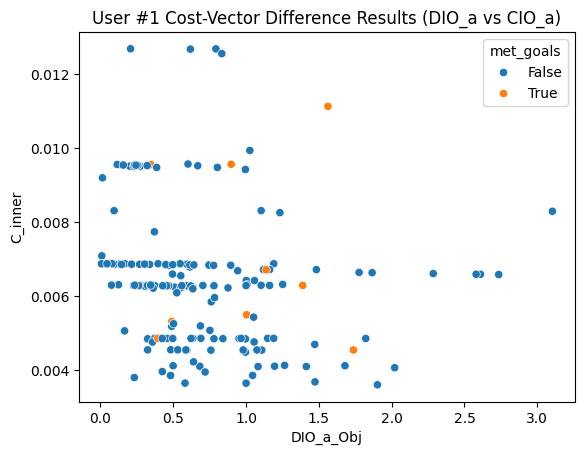

In [ ]:
sns.scatterplot(data=results, x="DIO_a_Obj", y="C_inner", hue="met_goals").set(title="User #1 Cost-Vector Difference Results (DIO_a vs CIO_a)")
print(len(results))
print(len(results[results.met_goals==True]))
print(len(results[results.met_goals==False]))
results.to_csv("data/output/User_1_DIO_a_vs_CIO_a.csv")

[48, 150, 57, 0, 94, 64]


Text(0.5, 0, 'Nutrient constraint')

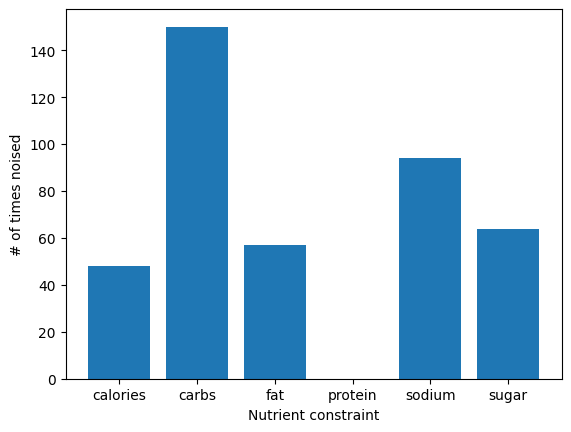

In [ ]:
constr_counts = [0, 0, 0, 0, 0, 0]
for i in range(len(np.array(results.tight_constrs))):
    if isinstance(np.array(results.tight_constrs)[i], list):
        for c in range(6):
            if c in np.array(results.tight_constrs)[i]:
                constr_counts[c] += 1

print(constr_counts)

plt.bar(x=['calories', 'carbs', 'fat', 'protein', 'sodium', 'sugar'], height=constr_counts)
plt.ylabel("# of times noised"); plt.xlabel("Nutrient constraint")

# New Framework Examples

## User 5587 (high-adherence)

In [26]:
# Filter for userID and calculate day for user
userID = 5587
userGoals = all_users[all_users['user_id']==userID]
userFoods = raw_foods[raw_foods['user_id']==userID]
print(len(userGoals), "daily entries with", len(userFoods), "total unique food items")

148 daily entries with 2894 total unique food items


In [27]:
# Each daily observation seperately
all_results = pd.DataFrame(columns=['Date'])

for d in range(len(userGoals)):
    date = userGoals.iloc[d].date
    print("Day", date, end=" (")
    if userGoals.iloc[d].met_goals == True: print("feasible", end="): ")
    else: print("infeasible", end="): ")

    A, b, x, foods = get_daily_params(userGoals, userFoods, date)
    print("Data loaded", end=", ")
    Z_DIO_a, DIO_a_C, DIO_a_Obj, DIO_a_rT = DIO_a(A,b,x)
    print("DIO_a done", end=", ")
    L, CIO_a_C, CIO_a_Obj, CIO_a_rT, tConstrs = CIO_a(A,b,x)
    print("CIO_a done")
    # Save optimization results
    # Food-specific results
    results = pd.DataFrame({'Foods': foods, 'Observation': x.T, 'Z_DIO_a': Z_DIO_a.T,
        'DIO_a Cost': DIO_a_C.T, 'CIO_a Cost': CIO_a_C.T[0][:-1],
        'A_calories': A[0,:], 'A_carbs': A[1,:], 'A_fat': A[2,:],
        'A_protein': A[3,:], 'A_sodium': A[4,:], 'A_sugar': A[5,:],
        'L_calories': L[0,:-1], 'L_carbs': L[1,:-1], 'L_fat': L[2,:-1],
        'L_protein': L[3,:-1], 'L_sodium': L[4,:-1], 'L_sugar': L[5,:-1]})
    b_results = pd.DataFrame({'Foods': "RHS constraints", 'Observation': 0, 'Z_DIO_a': 0,
        'DIO_a Cost': DIO_a_Obj, 'CIO_a Cost': CIO_a_Obj,
        'A_calories': b[0], 'A_carbs': b[1], 'A_fat': b[2],
        'A_protein': b[3], 'A_sodium': b[4], 'A_sugar': b[5],
        'L_calories': L[0,-1], 'L_carbs': L[1,-1], 'L_fat': L[2,-1],
        'L_protein': L[3,-1], 'L_sodium': L[4,-1], 'L_sugar': L[5,-1]}, index=[0])
    results = pd.concat((b_results, results), ignore_index=True)
    results.to_csv(root+"User"+str(userID)+"_"+date+"_CIOa.csv")
    # Overall results
    daily_results = pd.DataFrame({'Date': date, 'DIO_a_Obj':DIO_a_Obj, 'CIO_a_Obj':CIO_a_Obj,
            'DIO_a_rT':DIO_a_rT, 'CIO_a_rT':CIO_a_rT, 'met_goals':userGoals.iloc[d].met_goals,
            'tight_constrs':[tConstrs]}, index=[0])
    all_results = pd.concat((all_results, daily_results), ignore_index=True)

all_results.to_csv(root+"Summary_User"+str(userID)+"_CIOa.csv")

print("Done")


Day 2014-09-23 (feasible): 23 foods eaten, b: [1650.  206.   55.   82. 2300.   61.], Data loaded, Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-03
DIO_a done, CIO_a done
Day 2014-09-24 (infeasible): 25 foods eaten, b: [1650.  206.   55.   82. 2300.   61.], Data loaded, DIO_a done, CIO_a done
Day 2014-09-25 (feasible): 23 foods eaten, b: [1650.  206.   55.   82. 2300.   61.], Data loaded, DIO_a done, CIO_a done
Day 2014-09-26 (feasible): 22 foods eaten, b: [1650.  206.   55.   82. 2300.   61.], Data loaded, DIO_a done, CIO_a done
Day 2014-09-27 (feasible): 17 foods eaten, b: [1650.  206.   55.   82. 2300.   61.], Data loaded, DIO_a done, CIO_a done
Day 2014-09-29 (feasible): 22 foods eaten, b: [1650.  206.   55.   82. 2300.   61.], Data loaded, DIO_a done, CIO_a done
Day 2014-09-30 (feasible): 21 foods eaten, b: [1650.  206.   55.   82. 2300.   61.], Data loaded, DIO_a done, CIO_a done
Day 2014-10-01 (feasible): 26 foods eaten, b: [1650.  206.  

In [ ]:
# Multiple Observations together
dates = userGoals.iloc[0:5].date
A, b, X, foods = get_multi_params(userGoals, userFoods, dates)
print(A.shape); print(b.shape); print(X.shape)

45 foods eaten, b: [1480.  185.   49.  -74. 2300.   56.], (6, 45)
(6,)
(5, 45)


## User 3735 (low-adherence)

In [28]:
# Filter for userID and calculate day for user
userID = 3735
userGoals = all_users[all_users['user_id']==userID]
userFoods = raw_foods[raw_foods['user_id']==userID]
print(len(userGoals), "daily entries with", len(userFoods), "total unique food items")

142 daily entries with 1515 total unique food items


In [29]:
# Each daily observation seperately
all_results = pd.DataFrame(columns=['Date'])

for d in range(len(userGoals)):
    date = userGoals.iloc[d].date
    print("Day", date, end=" (")
    if userGoals.iloc[d].met_goals == True: print("feasible", end="): ")
    else: print("infeasible", end="): ")

    A, b, x, foods = get_daily_params(userGoals, userFoods, date)
    print("Data loaded", end=", ")
    Z_DIO_a, DIO_a_C, DIO_a_Obj, DIO_a_rT = DIO_a(A,b,x)
    print("DIO_a done", end=", ")
    L, CIO_a_C, CIO_a_Obj, CIO_a_rT, tConstrs = CIO_a(A,b,x)
    print("CIO_a done")
    # Save optimization results
    # Food-specific results
    results = pd.DataFrame({'Foods': foods, 'Observation': x.T, 'Z_DIO_a': Z_DIO_a.T,
        'DIO_a Cost': DIO_a_C.T, 'CIO_a Cost': CIO_a_C.T[0][:-1],
        'A_calories': A[0,:], 'A_carbs': A[1,:], 'A_fat': A[2,:],
        'A_protein': A[3,:], 'A_sodium': A[4,:], 'A_sugar': A[5,:],
        'L_calories': L[0,:-1], 'L_carbs': L[1,:-1], 'L_fat': L[2,:-1],
        'L_protein': L[3,:-1], 'L_sodium': L[4,:-1], 'L_sugar': L[5,:-1]})
    b_results = pd.DataFrame({'Foods': "RHS constraints", 'Observation': 0, 'Z_DIO_a': 0,
        'DIO_a Cost': DIO_a_Obj, 'CIO_a Cost': CIO_a_Obj,
        'A_calories': b[0], 'A_carbs': b[1], 'A_fat': b[2],
        'A_protein': b[3], 'A_sodium': b[4], 'A_sugar': b[5],
        'L_calories': L[0,-1], 'L_carbs': L[1,-1], 'L_fat': L[2,-1],
        'L_protein': L[3,-1], 'L_sodium': L[4,-1], 'L_sugar': L[5,-1]}, index=[0])
    results = pd.concat((b_results, results), ignore_index=True)
    results.to_csv(root+"User"+str(userID)+"_"+date+"_CIOa.csv")
    # Overall results
    daily_results = pd.DataFrame({'Date': date, 'DIO_a_Obj':DIO_a_Obj, 'CIO_a_Obj':CIO_a_Obj,
            'DIO_a_rT':DIO_a_rT, 'CIO_a_rT':CIO_a_rT, 'met_goals':userGoals.iloc[d].met_goals,
            'tight_constrs':[tConstrs]}, index=[0])
    all_results = pd.concat((all_results, daily_results), ignore_index=True)

all_results.to_csv(root+"Summary_User"+str(userID)+"_CIOa.csv")

print("Done")

Day 2014-09-29 (infeasible): 13 foods eaten, b: [1200.   30.   53.  150. 2300.   57.], Data loaded, DIO_a done, CIO_a done
Day 2014-09-30 (infeasible): 10 foods eaten, b: [1200.   30.   53.  150. 2300.   57.], Data loaded, DIO_a done, CIO_a done
Day 2014-10-01 (infeasible): 7 foods eaten, b: [1200.   30.   53.  150. 2300.   57.], Data loaded, DIO_a done, CIO_a done
Day 2014-10-02 (infeasible): 11 foods eaten, b: [1200.   30.   53.  150. 2300.   57.], Data loaded, DIO_a done, CIO_a done
Day 2014-10-03 (infeasible): 13 foods eaten, b: [1200.   30.   53.  150. 2300.   57.], Data loaded, DIO_a done, CIO_a done
Day 2014-10-04 (infeasible): 8 foods eaten, b: [1200.   30.   53.  150. 2300.   57.], Data loaded, DIO_a done, CIO_a done
Day 2014-10-05 (infeasible): 7 foods eaten, b: [1200.   30.   53.  150. 2300.   57.], Data loaded, DIO_a done, CIO_a done
Day 2014-10-06 (infeasible): 7 foods eaten, b: [1200.   30.   53.  150. 2300.   57.], Data loaded, DIO_a done, CIO_a done
Day 2014-10-07 (infe

## User 4920 (variable diet, consistent goals)

171 daily entries with 107 total unique food items


C:\Users\sprin\AppData\Local\Temp\ipykernel_9168\4070355429.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


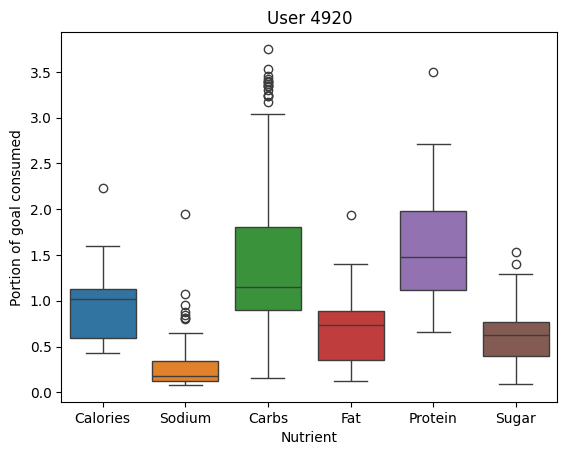

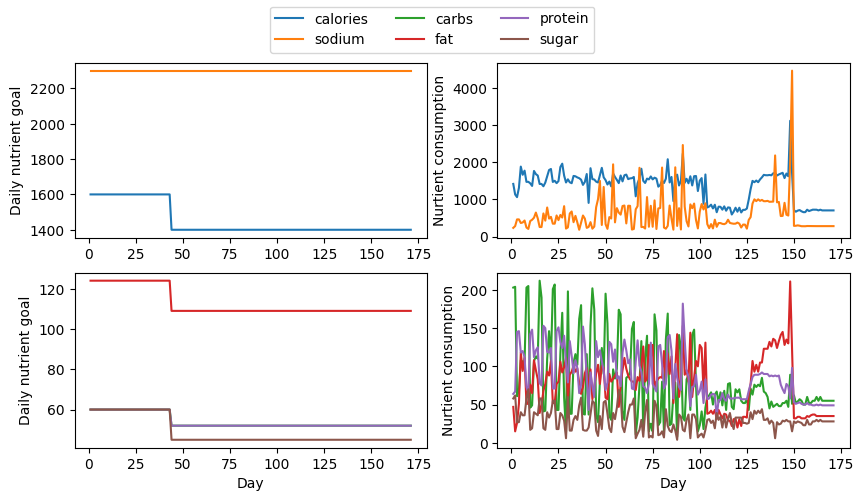

In [25]:
userID = 4920
userGoals, userFoods = init_user(userID, all_users)
model_dists = {}

In [116]:
dates = userGoals.date[90:95].values
print(dates[0], "through", dates[-1])
A, b, X, foods = model_params(userGoals, userFoods, dates)
print("A:", A.shape, ", b:", b.shape, ", X:", X.shape)

2014-12-17 through 2014-12-21
107 unique foods eaten, b: [ 1470.      54.6    114.45   104.    2415.      47.25 -1190.     -39.
   -81.75   -49.4  -1150.       0.  ], A: (12, 107) , b: (12,) , X: (5, 107)


In [117]:
# IL model
X_new1, AbsE, cost, obj, rT = IL_1c(A, b, X)
# Save optimization results
# Food-specific results
results = pd.DataFrame({'Foods': foods,
        'Observation 1': X[0].T, 'Recommendation 1': X_new1[0].T, 
        'Observation 2': X[1].T, 'Recommendation 2': X_new1[1].T, 
        'Observation 3': X[2].T, 'Recommendation 3': X_new1[2].T, 
        'A_calories': A[0,:], 'A_carbs': A[1,:], 'A_fat': A[2,:],
        'A_protein': A[3,:], 'A_sodium': A[4,:], 'A_sugar': A[5,:],})
b_results = pd.DataFrame({'Foods': "RHS constraints", 
        'Observation 1': None, 'Recommendation 1': None,  
        'Observation 2': None, 'Recommendation 2': None, 
        'Observation 3': None, 'Recommendation 3': None, 
        'A_calories': b[0], 'A_carbs': b[1], 'A_fat': b[2],
        'A_protein': b[3], 'A_sodium': b[4], 'A_sugar': b[5]}, index=[0])
results = pd.concat((b_results, results), ignore_index=True)
results.to_csv("data/output/User"+str(userID)+"/User"+str(userID)+"_IL_results.csv", float_format='%.15f')

day_dist = []
for k in range(len(X)):
    day_dist.append(gp.quicksum(abs(X_new1[k,i]-X[k,i]) for i in range(X.shape[1])).getValue())

model_dists["IL"] = day_dist

Optimization complete, objective value:  1.7177143708169131


C:\Users\sprin\AppData\Local\Temp\ipykernel_9168\411990727.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat((b_results, results), ignore_index=True)


Optimization complete, objective value:  1.2606276954170506


C:\Users\sprin\AppData\Local\Temp\ipykernel_9168\1357971143.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat((b_results, results), ignore_index=True)


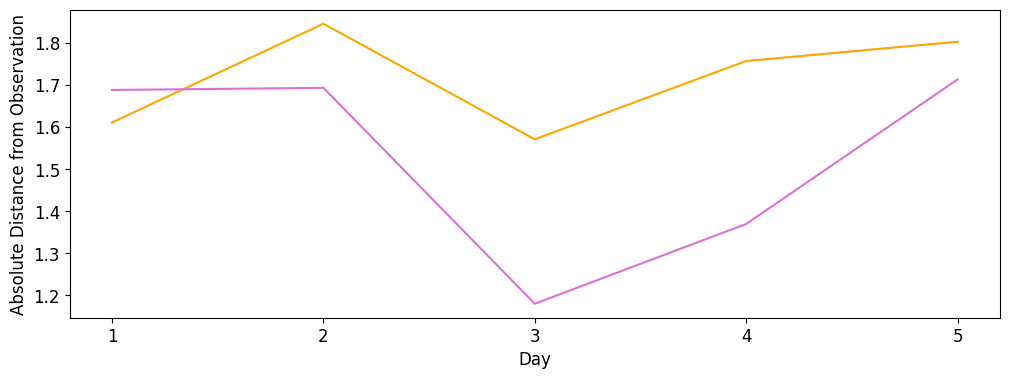

In [118]:
# Constraint and Decision-spaces Hybrid IO model
L, X_new2, AbsError, cost, obj, rT = CDH_IL1c(A, b, X, 0.10)
# Save optimization results
# Food-specific results
results = pd.DataFrame({'Foods': foods,
        'Observation 1': X[0].T, 'Recommendation 1': X_new2[0].T, 
        'Observation 2': X[1].T, 'Recommendation 2': X_new2[1].T, 
        'Observation 3': X[2].T, 'Recommendation 3': X_new2[2].T, 
        'A_calories': A[0,:], 'A_carbs': A[1,:], 'A_fat': A[2,:],
        'A_protein': A[3,:], 'A_sodium': A[4,:], 'A_sugar': A[5,:],
        'L_calories': L[0,:-1], 'L_carbs': L[1,:-1], 'L_fat': L[2,:-1],
        'L_protein': L[3,:-1], 'L_sodium': L[4,:-1], 'L_sugar': L[5,:-1]})
b_results = pd.DataFrame({'Foods': "RHS constraints", 
        'Observation 1': None, 'Recommendation 1': None,  
        'Observation 2': None, 'Recommendation 2': None, 
        'Observation 3': None, 'Recommendation 3': None, 
        'A_calories': b[0], 'A_carbs': b[1], 'A_fat': b[2],
        'A_protein': b[3], 'A_sodium': b[4], 'A_sugar': b[5],
        'L_calories': L[0,-1], 'L_carbs': L[1,-1], 'L_fat': L[2,-1],
        'L_protein': L[3,-1], 'L_sodium': L[4,-1], 'L_sugar': L[5,-1]}, index=[0])
results = pd.concat((b_results, results), ignore_index=True)
results.to_csv("data/output/User"+str(userID)+"/User"+str(userID)+"_CDH_IL_90-95_results.csv", float_format='%.15f')

d = 0
for day_ind in range(90,95):
    plt_rec_nuts(userID, userGoals, dates, X, X_new1, X_new2, A, b, L, d, day_ind, "90-95_Comb")
    plt_foods(userID, X, X_new1, X_new2, foods, d, "90-95_Comb")
    d+=1

day_dist = []
for k in range(len(X)):
    day_dist.append(gp.quicksum(abs(X_new2[k,i]-X[k,i]) for i in range(X.shape[1])).getValue())

model_dists["CDH_IL"] = day_dist

plt.figure(figsize=(12, 4))
plt.plot(np.arange(1, len(X)+1), model_dists["IL"], label="IL", color="orange")
plt.plot(np.arange(1, len(X)+1), model_dists["CDH_IL"], label="CDH_IL", color="orchid")
plt.xlabel("Day"); plt.ylabel("Absolute Distance from Observation")
plt.xticks(np.arange(1, len(X)+1))
# plt.legend()
plt.show()

In [105]:
d = 0
for day_ind in range(90,95):
    plt_rec_nuts(userID, userGoals, dates, X, X_new1, X_new2, A, b, L, d, day_ind, "1c_Comb")
    plt_foods(userID, X, X_new1, X_new2, foods, d, "1c_Comb")
    d+=1

In [106]:
day_dist = []
for k in range(len(X)):
    day_dist.append(gp.quicksum(abs(X_new2[k,i]-X[k,i]) for i in range(X.shape[1])).getValue())

model_dists["CDH_IL"] = day_dist

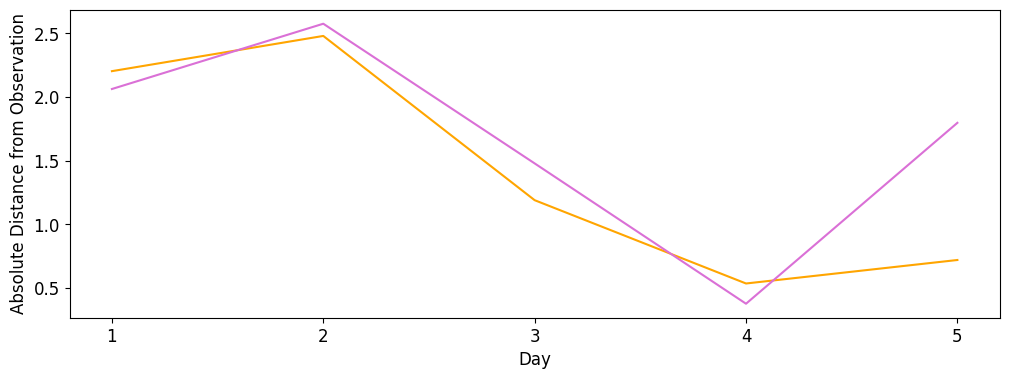

In [107]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(1, len(X)+1), model_dists["IL"], label="IL", color="orange")
plt.plot(np.arange(1, len(X)+1), model_dists["CDH_IL"], label="CDH_IL", color="orchid")
plt.xlabel("Day"); plt.ylabel("Absolute Distance from Observation")
plt.xticks(np.arange(1, len(X)+1))
# plt.legend()
plt.show()

## GRAPHS

In [42]:
data = pd.read_csv('fig2.csv')
# Data from the dictionary
food_items = list(data.columns)
food_items_cleaned = [item.split(',')[0] for item in food_items]
print(food_items_cleaned)

['Old Country Style Museli', 'Simply Granola', 'Chia seeds', 'Collagen peptides', 'Isopure Zero Carb Creamy Vanilla', 'Kefir', 'Cottage Cheese 4.5%', 'Nonfat Greek Yogurt', 'Strawberry', 'Blueberries', 'Blackberries', 'Nutella', 'Chopped Romaine', 'Spring mix', 'Cucumber', 'Avocado', 'Sauerkraut', 'Mozzarella Cheese', 'Olive oil', 'Thousand Island Dressing', 'Balsamic Vinager', 'Wheat Pasta', '85% Ground Beef', 'Pasta sauce', 'Olive oil', 'Chicken breast', 'Flatbread', 'Mortadella Panini', 'Pita', 'Gouda Cheese', 'Raisin Cookie', 'Plaintain Chips', 'Cheddar cheese', 'Plum', 'Ice Cream Bar']


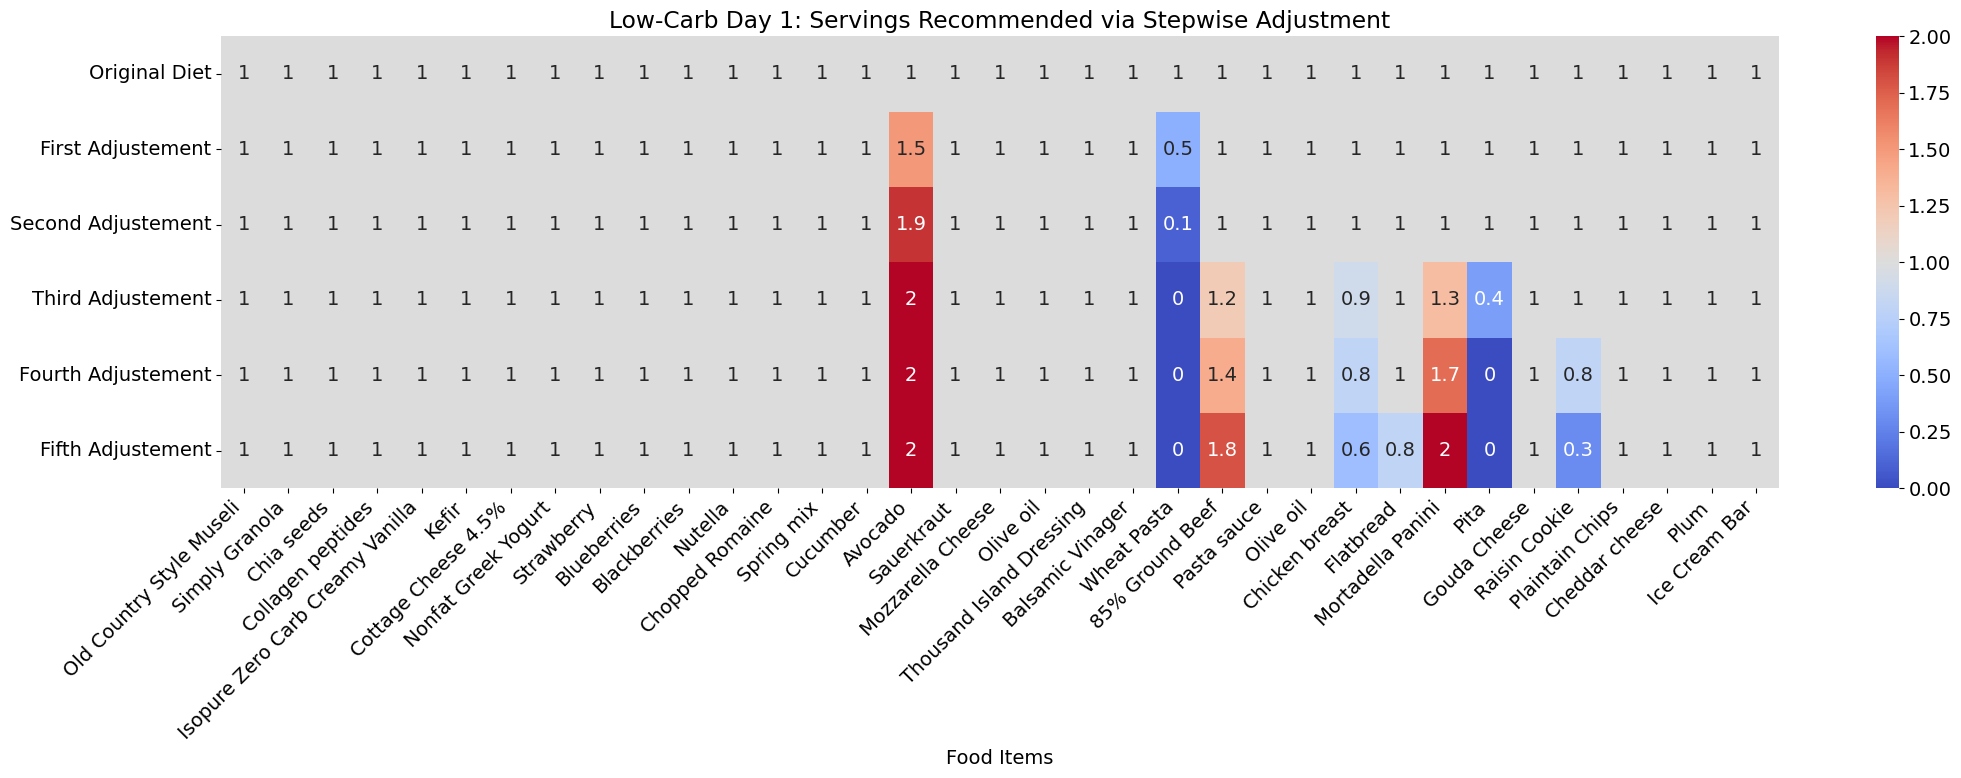

In [43]:
import seaborn as sns

# Data from the dictionary

# Convert the data into a format suitable for a heatmap
heatmap_data = np.array([data.iloc[i] for i in range(len(data))])

# Create a heatmap
plt.figure(figsize=(22, 8))
plt.rcParams.update({'font.size': 14})
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', xticklabels=food_items_cleaned, 
            yticklabels=['Original Diet', 'First Adjustement', 'Second Adjustement', 
                         'Third Adjustement', 'Fourth Adjustement', 'Fifth Adjustement'])

# Add labels and title
plt.title('Low-Carb Day 1: Servings Recommended via Stepwise Adjustment')
plt.xlabel('Food Items')

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to fit everything
plt.show()
